In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results


import ignite

import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist


ignite.utils.manual_seed(999)


ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)


from torchvision.datasets import ImageFolder



Random Seed:  999


In [2]:
image_size = 64

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = ImageFolder(root="C:\\Users\\Ilmu Komputer\\OneDrive\\Desktop\\CELEB GAN\\datasetCeleb\\archive\\105_classes_pins_dataset", transform=data_transform)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(1831))


In [3]:
batch_size = 32

train_dataloader = idist.auto_dataloader(
    train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True,
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=False,
    drop_last=True,
)


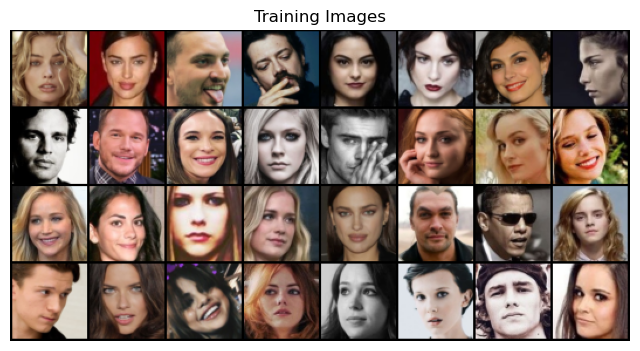

In [4]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [5]:
latent_dim = 100


In [6]:
class Generator3x64x64(nn.Module):
    def __init__(self, latent_dim):
        super(Generator3x64x64, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # final state size. 3 x 64 x 64
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [7]:
netG = idist.auto_model(Generator3x64x64(latent_dim))
idist.device()
summary(netG, (latent_dim, 1, 1))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [8]:
class Discriminator3x64x64(nn.Module):
    def __init__(self):
        super(Discriminator3x64x64, self).__init__()
        self.model = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [9]:
netD = idist.auto_model(Discriminator3x64x64())
summary(netD, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [10]:
criterion = nn.BCELoss()


In [11]:
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())


In [12]:
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)


In [13]:
real_label = 1
fake_label = 0


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()


    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }


In [14]:
trainer = Engine(training_step)


In [15]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [16]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)


In [17]:
G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])


In [18]:
img_list = []


@trainer.on(Events.COMPLETED)
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)


In [19]:
from ignite.metrics import FID, InceptionScore


In [20]:
fid_metric = FID(device=idist.device())


In [21]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])


In [22]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real


In [23]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")


In [24]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/2000] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")


In [25]:
from ignite.metrics import RunningAverage


RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')


In [26]:
from ignite.contrib.handlers import ProgressBar


ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)


C:\Users\Ilmu Komputer\miniconda3\envs\terbaru\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [27]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=2000)


In [28]:
with idist.Parallel(backend='gloo') as parallel:
    parallel.run(training)

[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1/2000] Metric Scores
*   FID : 0.170993
*    IS : 2.000746


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [2/2000] Metric Scores
*   FID : 0.089651
*    IS : 1.692954


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [3/2000] Metric Scores
*   FID : 0.074229
*    IS : 1.890042


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [4/2000] Metric Scores
*   FID : 0.080573
*    IS : 1.850486


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [5/2000] Metric Scores
*   FID : 0.050480
*    IS : 2.139172


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [6/2000] Metric Scores
*   FID : 0.046245
*    IS : 2.088749


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [7/2000] Metric Scores
*   FID : 0.034007
*    IS : 2.310693


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [8/2000] Metric Scores
*   FID : 0.036181
*    IS : 2.186119


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [9/2000] Metric Scores
*   FID : 0.022111
*    IS : 2.195925


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [10/2000] Metric Scores
*   FID : 0.026757
*    IS : 2.299689


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [11/2000] Metric Scores
*   FID : 0.030600
*    IS : 2.198267


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [12/2000] Metric Scores
*   FID : 0.031765
*    IS : 2.229084


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [13/2000] Metric Scores
*   FID : 0.042646
*    IS : 2.190534


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [14/2000] Metric Scores
*   FID : 0.029657
*    IS : 2.302781


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [15/2000] Metric Scores
*   FID : 0.034164
*    IS : 2.219337


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [16/2000] Metric Scores
*   FID : 0.030331
*    IS : 2.273908


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [17/2000] Metric Scores
*   FID : 0.029883
*    IS : 2.275550


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [18/2000] Metric Scores
*   FID : 0.035523
*    IS : 2.291833


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [19/2000] Metric Scores
*   FID : 0.040780
*    IS : 2.345705


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [20/2000] Metric Scores
*   FID : 0.032240
*    IS : 2.292079


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [21/2000] Metric Scores
*   FID : 0.035988
*    IS : 2.340088


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [22/2000] Metric Scores
*   FID : 0.036085
*    IS : 2.291623


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [23/2000] Metric Scores
*   FID : 0.038940
*    IS : 2.309957


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [24/2000] Metric Scores
*   FID : 0.037404
*    IS : 2.234872


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [25/2000] Metric Scores
*   FID : 0.039627
*    IS : 2.415214


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [26/2000] Metric Scores
*   FID : 0.030719
*    IS : 2.409211


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [27/2000] Metric Scores
*   FID : 0.044684
*    IS : 2.412579


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [28/2000] Metric Scores
*   FID : 0.034384
*    IS : 2.401124


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [29/2000] Metric Scores
*   FID : 0.028071
*    IS : 2.374373


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [30/2000] Metric Scores
*   FID : 0.035453
*    IS : 2.402049


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [31/2000] Metric Scores
*   FID : 0.036676
*    IS : 2.341448


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [32/2000] Metric Scores
*   FID : 0.036180
*    IS : 2.353215


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [33/2000] Metric Scores
*   FID : 0.032362
*    IS : 2.319159


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [34/2000] Metric Scores
*   FID : 0.034944
*    IS : 2.286456


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [35/2000] Metric Scores
*   FID : 0.032587
*    IS : 2.362750


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [36/2000] Metric Scores
*   FID : 0.029071
*    IS : 2.341968


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [37/2000] Metric Scores
*   FID : 0.026313
*    IS : 2.387342


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [38/2000] Metric Scores
*   FID : 0.028154
*    IS : 2.297191


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [39/2000] Metric Scores
*   FID : 0.032895
*    IS : 2.366337


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [40/2000] Metric Scores
*   FID : 0.030312
*    IS : 2.447197


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [41/2000] Metric Scores
*   FID : 0.026266
*    IS : 2.390850


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [42/2000] Metric Scores
*   FID : 0.033665
*    IS : 2.399204


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [43/2000] Metric Scores
*   FID : 0.027115
*    IS : 2.411167


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [44/2000] Metric Scores
*   FID : 0.033949
*    IS : 2.352514


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [45/2000] Metric Scores
*   FID : 0.023364
*    IS : 2.380274


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [46/2000] Metric Scores
*   FID : 0.026662
*    IS : 2.332374


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [47/2000] Metric Scores
*   FID : 0.027971
*    IS : 2.356891


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [48/2000] Metric Scores
*   FID : 0.025847
*    IS : 2.281900


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [49/2000] Metric Scores
*   FID : 0.022395
*    IS : 2.390986


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [50/2000] Metric Scores
*   FID : 0.030013
*    IS : 2.394448


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [51/2000] Metric Scores
*   FID : 0.023280
*    IS : 2.416128


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [52/2000] Metric Scores
*   FID : 0.031468
*    IS : 2.420851


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [53/2000] Metric Scores
*   FID : 0.027629
*    IS : 2.363814


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [54/2000] Metric Scores
*   FID : 0.030483
*    IS : 2.373807


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [55/2000] Metric Scores
*   FID : 0.029011
*    IS : 2.407640


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [56/2000] Metric Scores
*   FID : 0.029767
*    IS : 2.363665


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [57/2000] Metric Scores
*   FID : 0.028679
*    IS : 2.381056


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [58/2000] Metric Scores
*   FID : 0.031487
*    IS : 2.410412


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [59/2000] Metric Scores
*   FID : 0.028733
*    IS : 2.297745


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [60/2000] Metric Scores
*   FID : 0.029338
*    IS : 2.407862


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [61/2000] Metric Scores
*   FID : 0.033078
*    IS : 2.360900


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [62/2000] Metric Scores
*   FID : 0.025599
*    IS : 2.460772


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [63/2000] Metric Scores
*   FID : 0.025614
*    IS : 2.280211


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [64/2000] Metric Scores
*   FID : 0.024783
*    IS : 2.390023


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [65/2000] Metric Scores
*   FID : 0.027503
*    IS : 2.331910


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [66/2000] Metric Scores
*   FID : 0.026539
*    IS : 2.358385


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [67/2000] Metric Scores
*   FID : 0.025732
*    IS : 2.343320


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [68/2000] Metric Scores
*   FID : 0.028564
*    IS : 2.338166


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [69/2000] Metric Scores
*   FID : 0.021541
*    IS : 2.356108


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [70/2000] Metric Scores
*   FID : 0.023582
*    IS : 2.368825


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [71/2000] Metric Scores
*   FID : 0.030964
*    IS : 2.330145


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [72/2000] Metric Scores
*   FID : 0.021765
*    IS : 2.403017


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [73/2000] Metric Scores
*   FID : 0.022169
*    IS : 2.405379


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [74/2000] Metric Scores
*   FID : 0.035009
*    IS : 2.360406


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [75/2000] Metric Scores
*   FID : 0.023166
*    IS : 2.414656


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [76/2000] Metric Scores
*   FID : 0.028902
*    IS : 2.417295


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [77/2000] Metric Scores
*   FID : 0.027684
*    IS : 2.388161


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [78/2000] Metric Scores
*   FID : 0.024535
*    IS : 2.367663


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [79/2000] Metric Scores
*   FID : 0.028398
*    IS : 2.401486


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [80/2000] Metric Scores
*   FID : 0.025698
*    IS : 2.366723


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [81/2000] Metric Scores
*   FID : 0.023505
*    IS : 2.387225


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [82/2000] Metric Scores
*   FID : 0.019688
*    IS : 2.385603


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [83/2000] Metric Scores
*   FID : 0.029212
*    IS : 2.409114


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [84/2000] Metric Scores
*   FID : 0.022830
*    IS : 2.423039


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [85/2000] Metric Scores
*   FID : 0.020651
*    IS : 2.495930


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [86/2000] Metric Scores
*   FID : 0.019047
*    IS : 2.380143


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [87/2000] Metric Scores
*   FID : 0.025667
*    IS : 2.472258


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [88/2000] Metric Scores
*   FID : 0.021650
*    IS : 2.428694


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [89/2000] Metric Scores
*   FID : 0.020378
*    IS : 2.370437


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [90/2000] Metric Scores
*   FID : 0.024921
*    IS : 2.323962


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [91/2000] Metric Scores
*   FID : 0.027751
*    IS : 2.374736


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [92/2000] Metric Scores
*   FID : 0.021051
*    IS : 2.425313


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [93/2000] Metric Scores
*   FID : 0.029764
*    IS : 2.358830


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [94/2000] Metric Scores
*   FID : 0.027314
*    IS : 2.378708


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [95/2000] Metric Scores
*   FID : 0.027427
*    IS : 2.401065


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [96/2000] Metric Scores
*   FID : 0.024410
*    IS : 2.332693


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [97/2000] Metric Scores
*   FID : 0.020088
*    IS : 2.463592


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [98/2000] Metric Scores
*   FID : 0.133061
*    IS : 1.376184


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [99/2000] Metric Scores
*   FID : 0.131881
*    IS : 1.083530


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [100/2000] Metric Scores
*   FID : 0.131505
*    IS : 1.081660


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [101/2000] Metric Scores
*   FID : 0.131511
*    IS : 1.080186


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [102/2000] Metric Scores
*   FID : 0.132286
*    IS : 1.082546


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [103/2000] Metric Scores
*   FID : 0.131773
*    IS : 1.081995


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [104/2000] Metric Scores
*   FID : 0.131749
*    IS : 1.081815


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [105/2000] Metric Scores
*   FID : 0.132210
*    IS : 1.082652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [106/2000] Metric Scores
*   FID : 0.132219
*    IS : 1.082700


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [107/2000] Metric Scores
*   FID : 0.132254
*    IS : 1.081562


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [108/2000] Metric Scores
*   FID : 0.131386
*    IS : 1.080303


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [109/2000] Metric Scores
*   FID : 0.131864
*    IS : 1.082336


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [110/2000] Metric Scores
*   FID : 0.132122
*    IS : 1.084094


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [111/2000] Metric Scores
*   FID : 0.132216
*    IS : 1.081446


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [112/2000] Metric Scores
*   FID : 0.132631
*    IS : 1.083672


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [113/2000] Metric Scores
*   FID : 0.132569
*    IS : 1.085028


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [114/2000] Metric Scores
*   FID : 0.132821
*    IS : 1.083996


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [115/2000] Metric Scores
*   FID : 0.132527
*    IS : 1.083327


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [116/2000] Metric Scores
*   FID : 0.131661
*    IS : 1.080219


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [117/2000] Metric Scores
*   FID : 0.131787
*    IS : 1.080565


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [118/2000] Metric Scores
*   FID : 0.131856
*    IS : 1.081257


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [119/2000] Metric Scores
*   FID : 0.132303
*    IS : 1.081064


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [120/2000] Metric Scores
*   FID : 0.132236
*    IS : 1.084749


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [121/2000] Metric Scores
*   FID : 0.132200
*    IS : 1.083690


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [122/2000] Metric Scores
*   FID : 0.132138
*    IS : 1.082531


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [123/2000] Metric Scores
*   FID : 0.132191
*    IS : 1.081746


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [124/2000] Metric Scores
*   FID : 0.132126
*    IS : 1.085237


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [125/2000] Metric Scores
*   FID : 0.132080
*    IS : 1.084131


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [126/2000] Metric Scores
*   FID : 0.132206
*    IS : 1.083952


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [127/2000] Metric Scores
*   FID : 0.132088
*    IS : 1.082890


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [128/2000] Metric Scores
*   FID : 0.132240
*    IS : 1.085159


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [129/2000] Metric Scores
*   FID : 0.132128
*    IS : 1.085851


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [130/2000] Metric Scores
*   FID : 0.132114
*    IS : 1.083331


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [131/2000] Metric Scores
*   FID : 0.131692
*    IS : 1.080722


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [132/2000] Metric Scores
*   FID : 0.132081
*    IS : 1.081411


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [133/2000] Metric Scores
*   FID : 0.131986
*    IS : 1.082782


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [134/2000] Metric Scores
*   FID : 0.133538
*    IS : 1.538855


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [135/2000] Metric Scores
*   FID : 0.060320
*    IS : 2.073102


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [136/2000] Metric Scores
*   FID : 0.022149
*    IS : 2.299707


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [137/2000] Metric Scores
*   FID : 0.034530
*    IS : 2.362916


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [138/2000] Metric Scores
*   FID : 0.028818
*    IS : 2.351198


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [139/2000] Metric Scores
*   FID : 0.035219
*    IS : 2.328590


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [140/2000] Metric Scores
*   FID : 0.028250
*    IS : 2.534022


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [141/2000] Metric Scores
*   FID : 0.030468
*    IS : 2.479621


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [142/2000] Metric Scores
*   FID : 0.027427
*    IS : 2.278906


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [143/2000] Metric Scores
*   FID : 0.030045
*    IS : 2.404910


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [144/2000] Metric Scores
*   FID : 0.035624
*    IS : 2.395815


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [145/2000] Metric Scores
*   FID : 0.036413
*    IS : 2.496249


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [146/2000] Metric Scores
*   FID : 0.026738
*    IS : 2.451669


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [147/2000] Metric Scores
*   FID : 0.031989
*    IS : 2.416903


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [148/2000] Metric Scores
*   FID : 0.032876
*    IS : 2.499528


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [149/2000] Metric Scores
*   FID : 0.033532
*    IS : 2.374670


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [150/2000] Metric Scores
*   FID : 0.033007
*    IS : 2.463166


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [151/2000] Metric Scores
*   FID : 0.038140
*    IS : 2.379161


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [152/2000] Metric Scores
*   FID : 0.034477
*    IS : 2.454537


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [153/2000] Metric Scores
*   FID : 0.027833
*    IS : 2.299274


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [154/2000] Metric Scores
*   FID : 0.026698
*    IS : 2.411688


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [155/2000] Metric Scores
*   FID : 0.032363
*    IS : 2.355278


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [156/2000] Metric Scores
*   FID : 0.031256
*    IS : 2.349331


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [157/2000] Metric Scores
*   FID : 0.039850
*    IS : 2.402149


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [158/2000] Metric Scores
*   FID : 0.025599
*    IS : 2.444628


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [159/2000] Metric Scores
*   FID : 0.027845
*    IS : 2.431725


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [160/2000] Metric Scores
*   FID : 0.034136
*    IS : 2.406684


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [161/2000] Metric Scores
*   FID : 0.029653
*    IS : 2.445059


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [162/2000] Metric Scores
*   FID : 0.033550
*    IS : 2.396288


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [163/2000] Metric Scores
*   FID : 0.030689
*    IS : 2.387233


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [164/2000] Metric Scores
*   FID : 0.046653
*    IS : 2.354663


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [165/2000] Metric Scores
*   FID : 0.031095
*    IS : 2.394518


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [166/2000] Metric Scores
*   FID : 0.028189
*    IS : 2.470567


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [167/2000] Metric Scores
*   FID : 0.030641
*    IS : 2.347633


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [168/2000] Metric Scores
*   FID : 0.028000
*    IS : 2.427595


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [169/2000] Metric Scores
*   FID : 0.035180
*    IS : 2.457554


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [170/2000] Metric Scores
*   FID : 0.027994
*    IS : 2.446560


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [171/2000] Metric Scores
*   FID : 0.032476
*    IS : 2.405946


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [172/2000] Metric Scores
*   FID : 0.028705
*    IS : 2.454561


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [173/2000] Metric Scores
*   FID : 0.026596
*    IS : 2.446179


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [174/2000] Metric Scores
*   FID : 0.023040
*    IS : 2.397087


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [175/2000] Metric Scores
*   FID : 0.037993
*    IS : 2.398398


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [176/2000] Metric Scores
*   FID : 0.025550
*    IS : 2.413854


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [177/2000] Metric Scores
*   FID : 0.031975
*    IS : 2.434704


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [178/2000] Metric Scores
*   FID : 0.036392
*    IS : 2.385747


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [179/2000] Metric Scores
*   FID : 0.034197
*    IS : 2.393219


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [180/2000] Metric Scores
*   FID : 0.029177
*    IS : 2.370980


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [181/2000] Metric Scores
*   FID : 0.032223
*    IS : 2.445968


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [182/2000] Metric Scores
*   FID : 0.026211
*    IS : 2.397979


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [183/2000] Metric Scores
*   FID : 0.030738
*    IS : 2.406052


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [184/2000] Metric Scores
*   FID : 0.026121
*    IS : 2.484911


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [185/2000] Metric Scores
*   FID : 0.031695
*    IS : 2.315074


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [186/2000] Metric Scores
*   FID : 0.030744
*    IS : 2.443582


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [187/2000] Metric Scores
*   FID : 0.038289
*    IS : 2.365510


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [188/2000] Metric Scores
*   FID : 0.026720
*    IS : 2.522381


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [189/2000] Metric Scores
*   FID : 0.026629
*    IS : 2.375873


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [190/2000] Metric Scores
*   FID : 0.024559
*    IS : 2.416851


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [191/2000] Metric Scores
*   FID : 0.026768
*    IS : 2.416806


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [192/2000] Metric Scores
*   FID : 0.028252
*    IS : 2.449138


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [193/2000] Metric Scores
*   FID : 0.028326
*    IS : 2.400287


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [194/2000] Metric Scores
*   FID : 0.027524
*    IS : 2.434025


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [195/2000] Metric Scores
*   FID : 0.025179
*    IS : 2.390993


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [196/2000] Metric Scores
*   FID : 0.027055
*    IS : 2.432547


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [197/2000] Metric Scores
*   FID : 0.026795
*    IS : 2.510618


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [198/2000] Metric Scores
*   FID : 0.034693
*    IS : 2.421477


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [199/2000] Metric Scores
*   FID : 0.027696
*    IS : 2.448335


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [200/2000] Metric Scores
*   FID : 0.030176
*    IS : 2.424666


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [201/2000] Metric Scores
*   FID : 0.024086
*    IS : 2.402476


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [202/2000] Metric Scores
*   FID : 0.032012
*    IS : 2.394560


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [203/2000] Metric Scores
*   FID : 0.032199
*    IS : 2.414898


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [204/2000] Metric Scores
*   FID : 0.027175
*    IS : 2.435357


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [205/2000] Metric Scores
*   FID : 0.028463
*    IS : 2.413691


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [206/2000] Metric Scores
*   FID : 0.024537
*    IS : 2.425976


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [207/2000] Metric Scores
*   FID : 0.027415
*    IS : 2.441822


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [208/2000] Metric Scores
*   FID : 0.030323
*    IS : 2.413811


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [209/2000] Metric Scores
*   FID : 0.023071
*    IS : 2.447002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [210/2000] Metric Scores
*   FID : 0.025672
*    IS : 2.413754


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [211/2000] Metric Scores
*   FID : 0.031014
*    IS : 2.411767


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [212/2000] Metric Scores
*   FID : 0.030395
*    IS : 2.439669


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [213/2000] Metric Scores
*   FID : 0.025438
*    IS : 2.460028


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [214/2000] Metric Scores
*   FID : 0.029014
*    IS : 2.427778


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [215/2000] Metric Scores
*   FID : 0.037852
*    IS : 2.399079


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [216/2000] Metric Scores
*   FID : 0.027735
*    IS : 2.316679


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [217/2000] Metric Scores
*   FID : 0.032095
*    IS : 2.397342


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [218/2000] Metric Scores
*   FID : 0.032586
*    IS : 2.426749


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [219/2000] Metric Scores
*   FID : 0.022871
*    IS : 2.461715


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [220/2000] Metric Scores
*   FID : 0.033050
*    IS : 2.388029


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [221/2000] Metric Scores
*   FID : 0.027722
*    IS : 2.400608


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [222/2000] Metric Scores
*   FID : 0.031182
*    IS : 2.353347


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [223/2000] Metric Scores
*   FID : 0.029328
*    IS : 2.422002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [224/2000] Metric Scores
*   FID : 0.028715
*    IS : 2.371323


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [225/2000] Metric Scores
*   FID : 0.023017
*    IS : 2.408861


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [226/2000] Metric Scores
*   FID : 0.026316
*    IS : 2.438645


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [227/2000] Metric Scores
*   FID : 0.024643
*    IS : 2.461853


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [228/2000] Metric Scores
*   FID : 0.024443
*    IS : 2.395421


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [229/2000] Metric Scores
*   FID : 0.028634
*    IS : 2.484242


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [230/2000] Metric Scores
*   FID : 0.029745
*    IS : 2.336220


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [231/2000] Metric Scores
*   FID : 0.028585
*    IS : 2.386657


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [232/2000] Metric Scores
*   FID : 0.025673
*    IS : 2.455834


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [233/2000] Metric Scores
*   FID : 0.029275
*    IS : 2.429489


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [234/2000] Metric Scores
*   FID : 0.027665
*    IS : 2.433394


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [235/2000] Metric Scores
*   FID : 0.020712
*    IS : 2.406934


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [236/2000] Metric Scores
*   FID : 0.026459
*    IS : 2.489972


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [237/2000] Metric Scores
*   FID : 0.032949
*    IS : 2.419757


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [238/2000] Metric Scores
*   FID : 0.032914
*    IS : 2.424272


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [239/2000] Metric Scores
*   FID : 0.029122
*    IS : 2.377249


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [240/2000] Metric Scores
*   FID : 0.024836
*    IS : 2.405131


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [241/2000] Metric Scores
*   FID : 0.028125
*    IS : 2.503969


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [242/2000] Metric Scores
*   FID : 0.024373
*    IS : 2.357387


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [243/2000] Metric Scores
*   FID : 0.030343
*    IS : 2.475742


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [244/2000] Metric Scores
*   FID : 0.025518
*    IS : 2.456239


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [245/2000] Metric Scores
*   FID : 0.028859
*    IS : 2.442493


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [246/2000] Metric Scores
*   FID : 0.029442
*    IS : 2.384006


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [247/2000] Metric Scores
*   FID : 0.029883
*    IS : 2.412706


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [248/2000] Metric Scores
*   FID : 0.027865
*    IS : 2.467151


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [249/2000] Metric Scores
*   FID : 0.032195
*    IS : 2.429421


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [250/2000] Metric Scores
*   FID : 0.031239
*    IS : 2.307222


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [251/2000] Metric Scores
*   FID : 0.025776
*    IS : 2.484052


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [252/2000] Metric Scores
*   FID : 0.035307
*    IS : 2.433613


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [253/2000] Metric Scores
*   FID : 0.030647
*    IS : 2.370285


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [254/2000] Metric Scores
*   FID : 0.026246
*    IS : 2.463034


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [255/2000] Metric Scores
*   FID : 0.038890
*    IS : 2.391405


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [256/2000] Metric Scores
*   FID : 0.031567
*    IS : 2.528208


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [257/2000] Metric Scores
*   FID : 0.029917
*    IS : 2.419566


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [258/2000] Metric Scores
*   FID : 0.022689
*    IS : 2.469597


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [259/2000] Metric Scores
*   FID : 0.024363
*    IS : 2.499295


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [260/2000] Metric Scores
*   FID : 0.028552
*    IS : 2.391123


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [261/2000] Metric Scores
*   FID : 0.034001
*    IS : 2.457417


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [262/2000] Metric Scores
*   FID : 0.029836
*    IS : 2.422184


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [263/2000] Metric Scores
*   FID : 0.031647
*    IS : 2.439337


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [264/2000] Metric Scores
*   FID : 0.030713
*    IS : 2.464317


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [265/2000] Metric Scores
*   FID : 0.026594
*    IS : 2.310350


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [266/2000] Metric Scores
*   FID : 0.029146
*    IS : 2.484417


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [267/2000] Metric Scores
*   FID : 0.030770
*    IS : 2.392898


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [268/2000] Metric Scores
*   FID : 0.022168
*    IS : 2.508395


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [269/2000] Metric Scores
*   FID : 0.025991
*    IS : 2.459009


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [270/2000] Metric Scores
*   FID : 0.034228
*    IS : 2.567177


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [271/2000] Metric Scores
*   FID : 0.024065
*    IS : 2.501086


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [272/2000] Metric Scores
*   FID : 0.029497
*    IS : 2.447524


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [273/2000] Metric Scores
*   FID : 0.028351
*    IS : 2.421263


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [274/2000] Metric Scores
*   FID : 0.031430
*    IS : 2.381680


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [275/2000] Metric Scores
*   FID : 0.029477
*    IS : 2.361562


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [276/2000] Metric Scores
*   FID : 0.027598
*    IS : 2.503486


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [277/2000] Metric Scores
*   FID : 0.020420
*    IS : 2.421159


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [278/2000] Metric Scores
*   FID : 0.027178
*    IS : 2.353824


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [279/2000] Metric Scores
*   FID : 0.027524
*    IS : 2.419649


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [280/2000] Metric Scores
*   FID : 0.028801
*    IS : 2.382779


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [281/2000] Metric Scores
*   FID : 0.027257
*    IS : 2.320923


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [282/2000] Metric Scores
*   FID : 0.029631
*    IS : 2.435387


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [283/2000] Metric Scores
*   FID : 0.027737
*    IS : 2.499152


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [284/2000] Metric Scores
*   FID : 0.025853
*    IS : 2.391393


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [285/2000] Metric Scores
*   FID : 0.029438
*    IS : 2.524553


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [286/2000] Metric Scores
*   FID : 0.033497
*    IS : 2.453042


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [287/2000] Metric Scores
*   FID : 0.028043
*    IS : 2.552971


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [288/2000] Metric Scores
*   FID : 0.025684
*    IS : 2.458358


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [289/2000] Metric Scores
*   FID : 0.026102
*    IS : 2.525205


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [290/2000] Metric Scores
*   FID : 0.027927
*    IS : 2.465442


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [291/2000] Metric Scores
*   FID : 0.025962
*    IS : 2.444502


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [292/2000] Metric Scores
*   FID : 0.033905
*    IS : 2.359557


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [293/2000] Metric Scores
*   FID : 0.031776
*    IS : 2.371936


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [294/2000] Metric Scores
*   FID : 0.031440
*    IS : 2.384630


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [295/2000] Metric Scores
*   FID : 0.024390
*    IS : 2.513920


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [296/2000] Metric Scores
*   FID : 0.029328
*    IS : 2.445013


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [297/2000] Metric Scores
*   FID : 0.024987
*    IS : 2.482219


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [298/2000] Metric Scores
*   FID : 0.035663
*    IS : 2.386762


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [299/2000] Metric Scores
*   FID : 0.035441
*    IS : 2.454955


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [300/2000] Metric Scores
*   FID : 0.039415
*    IS : 2.448370


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [301/2000] Metric Scores
*   FID : 0.037522
*    IS : 2.514133


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [302/2000] Metric Scores
*   FID : 0.027905
*    IS : 2.414585


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [303/2000] Metric Scores
*   FID : 0.035235
*    IS : 2.390163


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [304/2000] Metric Scores
*   FID : 0.037390
*    IS : 2.412676


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [305/2000] Metric Scores
*   FID : 0.027800
*    IS : 2.537400


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [306/2000] Metric Scores
*   FID : 0.030508
*    IS : 2.447952


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [307/2000] Metric Scores
*   FID : 0.039317
*    IS : 2.519228


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [308/2000] Metric Scores
*   FID : 0.038983
*    IS : 2.491649


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [309/2000] Metric Scores
*   FID : 0.036048
*    IS : 2.355324


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [310/2000] Metric Scores
*   FID : 0.033600
*    IS : 2.368035


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [311/2000] Metric Scores
*   FID : 0.035357
*    IS : 2.510440


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [312/2000] Metric Scores
*   FID : 0.037862
*    IS : 2.490009


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [313/2000] Metric Scores
*   FID : 0.039768
*    IS : 2.392854


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [314/2000] Metric Scores
*   FID : 0.034411
*    IS : 2.474815


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [315/2000] Metric Scores
*   FID : 0.041572
*    IS : 2.529224


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [316/2000] Metric Scores
*   FID : 0.032870
*    IS : 2.436123


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [317/2000] Metric Scores
*   FID : 0.029528
*    IS : 2.444976


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [318/2000] Metric Scores
*   FID : 0.036216
*    IS : 2.401602


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [319/2000] Metric Scores
*   FID : 0.032862
*    IS : 2.423308


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [320/2000] Metric Scores
*   FID : 0.027321
*    IS : 2.462625


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [321/2000] Metric Scores
*   FID : 0.035383
*    IS : 2.484679


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [322/2000] Metric Scores
*   FID : 0.034524
*    IS : 2.384394


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [323/2000] Metric Scores
*   FID : 0.031581
*    IS : 2.400496


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [324/2000] Metric Scores
*   FID : 0.030544
*    IS : 2.425503


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [325/2000] Metric Scores
*   FID : 0.034744
*    IS : 2.461165


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [326/2000] Metric Scores
*   FID : 0.031849
*    IS : 2.511785


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [327/2000] Metric Scores
*   FID : 0.032456
*    IS : 2.532774


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [328/2000] Metric Scores
*   FID : 0.030546
*    IS : 2.351355


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [329/2000] Metric Scores
*   FID : 0.029502
*    IS : 2.466529


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [330/2000] Metric Scores
*   FID : 0.029867
*    IS : 2.499641


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [331/2000] Metric Scores
*   FID : 0.036787
*    IS : 2.516093


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [332/2000] Metric Scores
*   FID : 0.033584
*    IS : 2.459544


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [333/2000] Metric Scores
*   FID : 0.037496
*    IS : 2.472796


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [334/2000] Metric Scores
*   FID : 0.029846
*    IS : 2.508057


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [335/2000] Metric Scores
*   FID : 0.031641
*    IS : 2.486190


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [336/2000] Metric Scores
*   FID : 0.030782
*    IS : 2.448841


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [337/2000] Metric Scores
*   FID : 0.034410
*    IS : 2.353185


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [338/2000] Metric Scores
*   FID : 0.039786
*    IS : 2.490559


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [339/2000] Metric Scores
*   FID : 0.031798
*    IS : 2.406295


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [340/2000] Metric Scores
*   FID : 0.028396
*    IS : 2.561569


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [341/2000] Metric Scores
*   FID : 0.032614
*    IS : 2.380102


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [342/2000] Metric Scores
*   FID : 0.028141
*    IS : 2.476947


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [343/2000] Metric Scores
*   FID : 0.031649
*    IS : 2.538447


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [344/2000] Metric Scores
*   FID : 0.035334
*    IS : 2.483156


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [345/2000] Metric Scores
*   FID : 0.030406
*    IS : 2.392388


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [346/2000] Metric Scores
*   FID : 0.038997
*    IS : 2.308186


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [347/2000] Metric Scores
*   FID : 0.036988
*    IS : 2.460228


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [348/2000] Metric Scores
*   FID : 0.037340
*    IS : 2.372198


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [349/2000] Metric Scores
*   FID : 0.036343
*    IS : 2.378921


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [350/2000] Metric Scores
*   FID : 0.031804
*    IS : 2.462518


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [351/2000] Metric Scores
*   FID : 0.035623
*    IS : 2.402917


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [352/2000] Metric Scores
*   FID : 0.035037
*    IS : 2.458713


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [353/2000] Metric Scores
*   FID : 0.033766
*    IS : 2.425981


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [354/2000] Metric Scores
*   FID : 0.032461
*    IS : 2.440168


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [355/2000] Metric Scores
*   FID : 0.036588
*    IS : 2.459724


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [356/2000] Metric Scores
*   FID : 0.027466
*    IS : 2.366579


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [357/2000] Metric Scores
*   FID : 0.033547
*    IS : 2.487208


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [358/2000] Metric Scores
*   FID : 0.032134
*    IS : 2.514135


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [359/2000] Metric Scores
*   FID : 0.035339
*    IS : 2.546786


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [360/2000] Metric Scores
*   FID : 0.031210
*    IS : 2.410559


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [361/2000] Metric Scores
*   FID : 0.028363
*    IS : 2.462261


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [362/2000] Metric Scores
*   FID : 0.030666
*    IS : 2.382873


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [363/2000] Metric Scores
*   FID : 0.035151
*    IS : 2.417831


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [364/2000] Metric Scores
*   FID : 0.033201
*    IS : 2.379798


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [365/2000] Metric Scores
*   FID : 0.034745
*    IS : 2.601239


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [366/2000] Metric Scores
*   FID : 0.030785
*    IS : 2.499358


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [367/2000] Metric Scores
*   FID : 0.031842
*    IS : 2.426216


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [368/2000] Metric Scores
*   FID : 0.032283
*    IS : 2.543505


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [369/2000] Metric Scores
*   FID : 0.035855
*    IS : 2.420635


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [370/2000] Metric Scores
*   FID : 0.031987
*    IS : 2.286814


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [371/2000] Metric Scores
*   FID : 0.035607
*    IS : 2.445115


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [372/2000] Metric Scores
*   FID : 0.034549
*    IS : 2.415362


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [373/2000] Metric Scores
*   FID : 0.037844
*    IS : 2.507102


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [374/2000] Metric Scores
*   FID : 0.030735
*    IS : 2.345343


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [375/2000] Metric Scores
*   FID : 0.032983
*    IS : 2.481147


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [376/2000] Metric Scores
*   FID : 0.029125
*    IS : 2.540885


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [377/2000] Metric Scores
*   FID : 0.029060
*    IS : 2.422591


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [378/2000] Metric Scores
*   FID : 0.027392
*    IS : 2.531937


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [379/2000] Metric Scores
*   FID : 0.027944
*    IS : 2.663408


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [380/2000] Metric Scores
*   FID : 0.032452
*    IS : 2.439207


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [381/2000] Metric Scores
*   FID : 0.029047
*    IS : 2.405548


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [382/2000] Metric Scores
*   FID : 0.029938
*    IS : 2.482648


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [383/2000] Metric Scores
*   FID : 0.029443
*    IS : 2.463497


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [384/2000] Metric Scores
*   FID : 0.033242
*    IS : 2.511295


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [385/2000] Metric Scores
*   FID : 0.028993
*    IS : 2.453804


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [386/2000] Metric Scores
*   FID : 0.031159
*    IS : 2.463964


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [387/2000] Metric Scores
*   FID : 0.027362
*    IS : 2.410848


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [388/2000] Metric Scores
*   FID : 0.034916
*    IS : 2.245434


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [389/2000] Metric Scores
*   FID : 0.029811
*    IS : 2.359666


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [390/2000] Metric Scores
*   FID : 0.037590
*    IS : 2.501106


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [391/2000] Metric Scores
*   FID : 0.030252
*    IS : 2.383438


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [392/2000] Metric Scores
*   FID : 0.028154
*    IS : 2.444456


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [393/2000] Metric Scores
*   FID : 0.038866
*    IS : 2.368875


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [394/2000] Metric Scores
*   FID : 0.025665
*    IS : 2.431348


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [395/2000] Metric Scores
*   FID : 0.030862
*    IS : 2.484141


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [396/2000] Metric Scores
*   FID : 0.031589
*    IS : 2.524788


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [397/2000] Metric Scores
*   FID : 0.036843
*    IS : 2.424717


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [398/2000] Metric Scores
*   FID : 0.030048
*    IS : 2.505466


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [399/2000] Metric Scores
*   FID : 0.033961
*    IS : 2.512499


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [400/2000] Metric Scores
*   FID : 0.027967
*    IS : 2.393577


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [401/2000] Metric Scores
*   FID : 0.028788
*    IS : 2.505359


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [402/2000] Metric Scores
*   FID : 0.027448
*    IS : 2.399235


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [403/2000] Metric Scores
*   FID : 0.028845
*    IS : 2.463237


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [404/2000] Metric Scores
*   FID : 0.030731
*    IS : 2.488676


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [405/2000] Metric Scores
*   FID : 0.031173
*    IS : 2.598119


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [406/2000] Metric Scores
*   FID : 0.035684
*    IS : 2.453158


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [407/2000] Metric Scores
*   FID : 0.030127
*    IS : 2.472134


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [408/2000] Metric Scores
*   FID : 0.026343
*    IS : 2.433065


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [409/2000] Metric Scores
*   FID : 0.030566
*    IS : 2.399363


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [410/2000] Metric Scores
*   FID : 0.028923
*    IS : 2.461797


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [411/2000] Metric Scores
*   FID : 0.034533
*    IS : 2.467152


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [412/2000] Metric Scores
*   FID : 0.031564
*    IS : 2.379373


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [413/2000] Metric Scores
*   FID : 0.028834
*    IS : 2.369206


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [414/2000] Metric Scores
*   FID : 0.026801
*    IS : 2.482254


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [415/2000] Metric Scores
*   FID : 0.037542
*    IS : 2.379419


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [416/2000] Metric Scores
*   FID : 0.029801
*    IS : 2.454978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [417/2000] Metric Scores
*   FID : 0.029814
*    IS : 2.460164


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [418/2000] Metric Scores
*   FID : 0.034058
*    IS : 2.515823


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [419/2000] Metric Scores
*   FID : 0.036123
*    IS : 2.409719


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [420/2000] Metric Scores
*   FID : 0.034348
*    IS : 2.370960


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [421/2000] Metric Scores
*   FID : 0.033456
*    IS : 2.484661


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [422/2000] Metric Scores
*   FID : 0.036463
*    IS : 2.446905


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [423/2000] Metric Scores
*   FID : 0.031948
*    IS : 2.500880


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [424/2000] Metric Scores
*   FID : 0.031022
*    IS : 2.430702


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [425/2000] Metric Scores
*   FID : 0.033272
*    IS : 2.362320


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [426/2000] Metric Scores
*   FID : 0.032206
*    IS : 2.377115


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [427/2000] Metric Scores
*   FID : 0.029070
*    IS : 2.442234


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [428/2000] Metric Scores
*   FID : 0.038519
*    IS : 2.524404


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [429/2000] Metric Scores
*   FID : 0.031855
*    IS : 2.494455


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [430/2000] Metric Scores
*   FID : 0.034457
*    IS : 2.311193


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [431/2000] Metric Scores
*   FID : 0.026072
*    IS : 2.435811


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [432/2000] Metric Scores
*   FID : 0.033688
*    IS : 2.450284


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [433/2000] Metric Scores
*   FID : 0.033024
*    IS : 2.377453


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [434/2000] Metric Scores
*   FID : 0.032230
*    IS : 2.455018


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [435/2000] Metric Scores
*   FID : 0.040280
*    IS : 2.443345


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [436/2000] Metric Scores
*   FID : 0.034299
*    IS : 2.430534


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [437/2000] Metric Scores
*   FID : 0.035288
*    IS : 2.445011


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [438/2000] Metric Scores
*   FID : 0.040177
*    IS : 2.544029


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [439/2000] Metric Scores
*   FID : 0.032363
*    IS : 2.390084


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [440/2000] Metric Scores
*   FID : 0.035775
*    IS : 2.380033


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [441/2000] Metric Scores
*   FID : 0.032782
*    IS : 2.612767


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [442/2000] Metric Scores
*   FID : 0.030971
*    IS : 2.425397


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [443/2000] Metric Scores
*   FID : 0.029943
*    IS : 2.520144


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [444/2000] Metric Scores
*   FID : 0.037150
*    IS : 2.503461


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [445/2000] Metric Scores
*   FID : 0.028891
*    IS : 2.398214


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [446/2000] Metric Scores
*   FID : 0.028255
*    IS : 2.418569


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [447/2000] Metric Scores
*   FID : 0.033731
*    IS : 2.391842


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [448/2000] Metric Scores
*   FID : 0.033134
*    IS : 2.549089


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [449/2000] Metric Scores
*   FID : 0.028421
*    IS : 2.518496


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [450/2000] Metric Scores
*   FID : 0.033403
*    IS : 2.393881


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [451/2000] Metric Scores
*   FID : 0.037456
*    IS : 2.389170


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [452/2000] Metric Scores
*   FID : 0.029495
*    IS : 2.487147


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [453/2000] Metric Scores
*   FID : 0.027608
*    IS : 2.495032


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [454/2000] Metric Scores
*   FID : 0.035027
*    IS : 2.468435


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [455/2000] Metric Scores
*   FID : 0.032810
*    IS : 2.538184


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [456/2000] Metric Scores
*   FID : 0.039323
*    IS : 2.402865


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [457/2000] Metric Scores
*   FID : 0.027035
*    IS : 2.488903


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [458/2000] Metric Scores
*   FID : 0.030186
*    IS : 2.550557


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [459/2000] Metric Scores
*   FID : 0.042195
*    IS : 2.394586


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [460/2000] Metric Scores
*   FID : 0.035200
*    IS : 2.382137


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [461/2000] Metric Scores
*   FID : 0.034208
*    IS : 2.437263


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [462/2000] Metric Scores
*   FID : 0.034756
*    IS : 2.458984


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [463/2000] Metric Scores
*   FID : 0.035419
*    IS : 2.459989


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [464/2000] Metric Scores
*   FID : 0.035602
*    IS : 2.644409


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [465/2000] Metric Scores
*   FID : 0.038631
*    IS : 2.495192


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [466/2000] Metric Scores
*   FID : 0.026659
*    IS : 2.451750


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [467/2000] Metric Scores
*   FID : 0.031624
*    IS : 2.583017


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [468/2000] Metric Scores
*   FID : 0.035913
*    IS : 2.468001


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [469/2000] Metric Scores
*   FID : 0.035177
*    IS : 2.450535


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [470/2000] Metric Scores
*   FID : 0.029109
*    IS : 2.502032


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [471/2000] Metric Scores
*   FID : 0.037198
*    IS : 2.541177


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [472/2000] Metric Scores
*   FID : 0.033708
*    IS : 2.426970


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [473/2000] Metric Scores
*   FID : 0.034254
*    IS : 2.437118


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [474/2000] Metric Scores
*   FID : 0.026016
*    IS : 2.544231


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [475/2000] Metric Scores
*   FID : 0.029586
*    IS : 2.402793


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [476/2000] Metric Scores
*   FID : 0.034565
*    IS : 2.472087


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [477/2000] Metric Scores
*   FID : 0.037267
*    IS : 2.335358


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [478/2000] Metric Scores
*   FID : 0.042643
*    IS : 2.339230


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [479/2000] Metric Scores
*   FID : 0.036196
*    IS : 2.403043


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [480/2000] Metric Scores
*   FID : 0.035667
*    IS : 2.216114


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [481/2000] Metric Scores
*   FID : 0.028571
*    IS : 2.465460


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [482/2000] Metric Scores
*   FID : 0.031523
*    IS : 2.471140


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [483/2000] Metric Scores
*   FID : 0.031339
*    IS : 2.496772


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [484/2000] Metric Scores
*   FID : 0.039222
*    IS : 2.510312


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [485/2000] Metric Scores
*   FID : 0.043683
*    IS : 2.409694


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [486/2000] Metric Scores
*   FID : 0.039130
*    IS : 2.550637


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [487/2000] Metric Scores
*   FID : 0.030985
*    IS : 2.425824


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [488/2000] Metric Scores
*   FID : 0.033614
*    IS : 2.431799


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [489/2000] Metric Scores
*   FID : 0.034611
*    IS : 2.452036


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [490/2000] Metric Scores
*   FID : 0.032347
*    IS : 2.459458


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [491/2000] Metric Scores
*   FID : 0.033655
*    IS : 2.479291


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [492/2000] Metric Scores
*   FID : 0.038107
*    IS : 2.556923


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [493/2000] Metric Scores
*   FID : 0.029624
*    IS : 2.582383


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [494/2000] Metric Scores
*   FID : 0.029579
*    IS : 2.364267


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [495/2000] Metric Scores
*   FID : 0.038785
*    IS : 2.548283


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [496/2000] Metric Scores
*   FID : 0.045837
*    IS : 2.489428


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [497/2000] Metric Scores
*   FID : 0.034480
*    IS : 2.410416


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [498/2000] Metric Scores
*   FID : 0.035002
*    IS : 2.508956


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [499/2000] Metric Scores
*   FID : 0.028283
*    IS : 2.487724


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [500/2000] Metric Scores
*   FID : 0.035550
*    IS : 2.511767


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [501/2000] Metric Scores
*   FID : 0.034079
*    IS : 2.547528


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [502/2000] Metric Scores
*   FID : 0.029566
*    IS : 2.471992


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [503/2000] Metric Scores
*   FID : 0.040507
*    IS : 2.465042


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [504/2000] Metric Scores
*   FID : 0.034381
*    IS : 2.502893


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [505/2000] Metric Scores
*   FID : 0.027597
*    IS : 2.481624


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [506/2000] Metric Scores
*   FID : 0.029823
*    IS : 2.473331


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [507/2000] Metric Scores
*   FID : 0.036785
*    IS : 2.431812


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [508/2000] Metric Scores
*   FID : 0.032203
*    IS : 2.335813


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [509/2000] Metric Scores
*   FID : 0.033922
*    IS : 2.348120


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [510/2000] Metric Scores
*   FID : 0.031306
*    IS : 2.453832


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [511/2000] Metric Scores
*   FID : 0.039133
*    IS : 2.503454


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [512/2000] Metric Scores
*   FID : 0.046087
*    IS : 2.285031


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [513/2000] Metric Scores
*   FID : 0.035903
*    IS : 2.309420


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [514/2000] Metric Scores
*   FID : 0.035270
*    IS : 2.385688


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [515/2000] Metric Scores
*   FID : 0.037826
*    IS : 2.423992


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [516/2000] Metric Scores
*   FID : 0.030681
*    IS : 2.465998


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [517/2000] Metric Scores
*   FID : 0.025614
*    IS : 2.498834


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [518/2000] Metric Scores
*   FID : 0.031513
*    IS : 2.447955


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [519/2000] Metric Scores
*   FID : 0.035375
*    IS : 2.462300


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [520/2000] Metric Scores
*   FID : 0.029172
*    IS : 2.588562


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [521/2000] Metric Scores
*   FID : 0.031134
*    IS : 2.360348


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [522/2000] Metric Scores
*   FID : 0.037157
*    IS : 2.467331


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [523/2000] Metric Scores
*   FID : 0.045999
*    IS : 2.386873


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [524/2000] Metric Scores
*   FID : 0.031941
*    IS : 2.331735


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [525/2000] Metric Scores
*   FID : 0.033777
*    IS : 2.264639


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [526/2000] Metric Scores
*   FID : 0.039210
*    IS : 2.458751


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [527/2000] Metric Scores
*   FID : 0.037223
*    IS : 2.506099


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [528/2000] Metric Scores
*   FID : 0.030188
*    IS : 2.512455


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [529/2000] Metric Scores
*   FID : 0.046544
*    IS : 2.354784


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [530/2000] Metric Scores
*   FID : 0.039940
*    IS : 2.553578


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [531/2000] Metric Scores
*   FID : 0.031044
*    IS : 2.463782


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [532/2000] Metric Scores
*   FID : 0.035188
*    IS : 2.538537


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [533/2000] Metric Scores
*   FID : 0.033430
*    IS : 2.541525


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [534/2000] Metric Scores
*   FID : 0.031749
*    IS : 2.422431


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [535/2000] Metric Scores
*   FID : 0.032070
*    IS : 2.390434


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [536/2000] Metric Scores
*   FID : 0.034160
*    IS : 2.351133


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [537/2000] Metric Scores
*   FID : 0.030578
*    IS : 2.320866


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [538/2000] Metric Scores
*   FID : 0.034116
*    IS : 2.443586


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [539/2000] Metric Scores
*   FID : 0.035870
*    IS : 2.509790


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [540/2000] Metric Scores
*   FID : 0.041364
*    IS : 2.532870


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [541/2000] Metric Scores
*   FID : 0.034652
*    IS : 2.454458


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [542/2000] Metric Scores
*   FID : 0.031748
*    IS : 2.516256


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [543/2000] Metric Scores
*   FID : 0.039262
*    IS : 2.435625


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [544/2000] Metric Scores
*   FID : 0.036435
*    IS : 2.317062


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [545/2000] Metric Scores
*   FID : 0.043799
*    IS : 2.486503


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [546/2000] Metric Scores
*   FID : 0.036701
*    IS : 2.448593


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [547/2000] Metric Scores
*   FID : 0.038448
*    IS : 2.377608


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [548/2000] Metric Scores
*   FID : 0.032869
*    IS : 2.589594


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [549/2000] Metric Scores
*   FID : 0.032920
*    IS : 2.461888


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [550/2000] Metric Scores
*   FID : 0.031645
*    IS : 2.306911


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [551/2000] Metric Scores
*   FID : 0.029720
*    IS : 2.512435


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [552/2000] Metric Scores
*   FID : 0.036038
*    IS : 2.344660


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [553/2000] Metric Scores
*   FID : 0.040193
*    IS : 2.428158


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [554/2000] Metric Scores
*   FID : 0.038566
*    IS : 2.617264


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [555/2000] Metric Scores
*   FID : 0.034513
*    IS : 2.417789


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [556/2000] Metric Scores
*   FID : 0.035460
*    IS : 2.476827


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [557/2000] Metric Scores
*   FID : 0.030253
*    IS : 2.360629


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [558/2000] Metric Scores
*   FID : 0.036040
*    IS : 2.355740


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [559/2000] Metric Scores
*   FID : 0.036898
*    IS : 2.472627


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [560/2000] Metric Scores
*   FID : 0.034662
*    IS : 2.576811


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [561/2000] Metric Scores
*   FID : 0.032635
*    IS : 2.615572


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [562/2000] Metric Scores
*   FID : 0.034527
*    IS : 2.437467


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [563/2000] Metric Scores
*   FID : 0.029957
*    IS : 2.517376


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [564/2000] Metric Scores
*   FID : 0.038412
*    IS : 2.502428


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [565/2000] Metric Scores
*   FID : 0.034273
*    IS : 2.490075


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [566/2000] Metric Scores
*   FID : 0.036404
*    IS : 2.526980


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [567/2000] Metric Scores
*   FID : 0.034463
*    IS : 2.508577


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [568/2000] Metric Scores
*   FID : 0.030623
*    IS : 2.361705


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [569/2000] Metric Scores
*   FID : 0.034631
*    IS : 2.458545


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [570/2000] Metric Scores
*   FID : 0.033234
*    IS : 2.505265


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [571/2000] Metric Scores
*   FID : 0.025606
*    IS : 2.541102


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [572/2000] Metric Scores
*   FID : 0.027228
*    IS : 2.428969


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [573/2000] Metric Scores
*   FID : 0.032692
*    IS : 2.332745


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [574/2000] Metric Scores
*   FID : 0.034398
*    IS : 2.479162


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [575/2000] Metric Scores
*   FID : 0.038862
*    IS : 2.311527


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [576/2000] Metric Scores
*   FID : 0.030382
*    IS : 2.420539


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [577/2000] Metric Scores
*   FID : 0.032255
*    IS : 2.372237


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [578/2000] Metric Scores
*   FID : 0.029358
*    IS : 2.471060


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [579/2000] Metric Scores
*   FID : 0.040772
*    IS : 2.431020


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [580/2000] Metric Scores
*   FID : 0.031788
*    IS : 2.404178


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [581/2000] Metric Scores
*   FID : 0.030507
*    IS : 2.370978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [582/2000] Metric Scores
*   FID : 0.036581
*    IS : 2.497606


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [583/2000] Metric Scores
*   FID : 0.035447
*    IS : 2.501645


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [584/2000] Metric Scores
*   FID : 0.034987
*    IS : 2.489539


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [585/2000] Metric Scores
*   FID : 0.034332
*    IS : 2.537225


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [586/2000] Metric Scores
*   FID : 0.033793
*    IS : 2.541480


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [587/2000] Metric Scores
*   FID : 0.032141
*    IS : 2.446875


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [588/2000] Metric Scores
*   FID : 0.035428
*    IS : 2.428072


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [589/2000] Metric Scores
*   FID : 0.034768
*    IS : 2.522418


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [590/2000] Metric Scores
*   FID : 0.032375
*    IS : 2.413839


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [591/2000] Metric Scores
*   FID : 0.036646
*    IS : 2.424501


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [592/2000] Metric Scores
*   FID : 0.034315
*    IS : 2.519978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [593/2000] Metric Scores
*   FID : 0.034910
*    IS : 2.471276


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [594/2000] Metric Scores
*   FID : 0.032739
*    IS : 2.405715


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [595/2000] Metric Scores
*   FID : 0.028762
*    IS : 2.632195


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [596/2000] Metric Scores
*   FID : 0.035484
*    IS : 2.550928


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [597/2000] Metric Scores
*   FID : 0.040792
*    IS : 2.475237


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [598/2000] Metric Scores
*   FID : 0.037725
*    IS : 2.476108


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [599/2000] Metric Scores
*   FID : 0.037371
*    IS : 2.353543


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [600/2000] Metric Scores
*   FID : 0.036831
*    IS : 2.534523


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [601/2000] Metric Scores
*   FID : 0.042773
*    IS : 2.498367


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [602/2000] Metric Scores
*   FID : 0.036953
*    IS : 2.474903


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [603/2000] Metric Scores
*   FID : 0.032840
*    IS : 2.476537


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [604/2000] Metric Scores
*   FID : 0.038055
*    IS : 2.501461


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [605/2000] Metric Scores
*   FID : 0.040999
*    IS : 2.407936


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [606/2000] Metric Scores
*   FID : 0.037103
*    IS : 2.384504


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [607/2000] Metric Scores
*   FID : 0.033856
*    IS : 2.404061


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [608/2000] Metric Scores
*   FID : 0.036737
*    IS : 2.509667


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [609/2000] Metric Scores
*   FID : 0.042734
*    IS : 2.499956


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [610/2000] Metric Scores
*   FID : 0.037192
*    IS : 2.568826


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [611/2000] Metric Scores
*   FID : 0.041082
*    IS : 2.348051


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [612/2000] Metric Scores
*   FID : 0.038039
*    IS : 2.545043


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [613/2000] Metric Scores
*   FID : 0.035561
*    IS : 2.430433


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [614/2000] Metric Scores
*   FID : 0.034682
*    IS : 2.555027


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [615/2000] Metric Scores
*   FID : 0.038319
*    IS : 2.405937


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [616/2000] Metric Scores
*   FID : 0.038750
*    IS : 2.480963


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [617/2000] Metric Scores
*   FID : 0.033762
*    IS : 2.288177


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [618/2000] Metric Scores
*   FID : 0.034888
*    IS : 2.349745


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [619/2000] Metric Scores
*   FID : 0.036722
*    IS : 2.517745


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [620/2000] Metric Scores
*   FID : 0.035627
*    IS : 2.556455


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [621/2000] Metric Scores
*   FID : 0.036327
*    IS : 2.363990


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [622/2000] Metric Scores
*   FID : 0.036883
*    IS : 2.481399


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [623/2000] Metric Scores
*   FID : 0.030492
*    IS : 2.419033


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [624/2000] Metric Scores
*   FID : 0.032366
*    IS : 2.469881


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [625/2000] Metric Scores
*   FID : 0.034537
*    IS : 2.584115


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [626/2000] Metric Scores
*   FID : 0.038200
*    IS : 2.609510


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [627/2000] Metric Scores
*   FID : 0.029517
*    IS : 2.501446


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [628/2000] Metric Scores
*   FID : 0.036814
*    IS : 2.422478


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [629/2000] Metric Scores
*   FID : 0.037405
*    IS : 2.430143


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [630/2000] Metric Scores
*   FID : 0.038585
*    IS : 2.548538


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [631/2000] Metric Scores
*   FID : 0.038180
*    IS : 2.619131


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [632/2000] Metric Scores
*   FID : 0.028817
*    IS : 2.604201


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [633/2000] Metric Scores
*   FID : 0.038051
*    IS : 2.418574


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [634/2000] Metric Scores
*   FID : 0.039891
*    IS : 2.464678


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [635/2000] Metric Scores
*   FID : 0.029781
*    IS : 2.491229


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [636/2000] Metric Scores
*   FID : 0.039762
*    IS : 2.497295


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [637/2000] Metric Scores
*   FID : 0.033742
*    IS : 2.463135


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [638/2000] Metric Scores
*   FID : 0.045709
*    IS : 2.523110


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [639/2000] Metric Scores
*   FID : 0.032799
*    IS : 2.525853


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [640/2000] Metric Scores
*   FID : 0.039480
*    IS : 2.512848


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [641/2000] Metric Scores
*   FID : 0.036568
*    IS : 2.496839


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [642/2000] Metric Scores
*   FID : 0.041655
*    IS : 2.461145


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [643/2000] Metric Scores
*   FID : 0.035988
*    IS : 2.514404


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [644/2000] Metric Scores
*   FID : 0.031626
*    IS : 2.441321


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [645/2000] Metric Scores
*   FID : 0.034073
*    IS : 2.381107


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [646/2000] Metric Scores
*   FID : 0.041005
*    IS : 2.531227


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [647/2000] Metric Scores
*   FID : 0.037920
*    IS : 2.519539


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [648/2000] Metric Scores
*   FID : 0.044560
*    IS : 2.644990


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [649/2000] Metric Scores
*   FID : 0.041024
*    IS : 2.607357


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [650/2000] Metric Scores
*   FID : 0.037448
*    IS : 2.456936


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [651/2000] Metric Scores
*   FID : 0.038985
*    IS : 2.544148


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [652/2000] Metric Scores
*   FID : 0.035139
*    IS : 2.394905


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [653/2000] Metric Scores
*   FID : 0.033013
*    IS : 2.570433


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [654/2000] Metric Scores
*   FID : 0.040754
*    IS : 2.464452


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [655/2000] Metric Scores
*   FID : 0.034700
*    IS : 2.405425


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [656/2000] Metric Scores
*   FID : 0.033398
*    IS : 2.458028


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [657/2000] Metric Scores
*   FID : 0.038184
*    IS : 2.591528


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [658/2000] Metric Scores
*   FID : 0.038429
*    IS : 2.525333


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [659/2000] Metric Scores
*   FID : 0.033893
*    IS : 2.370686


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [660/2000] Metric Scores
*   FID : 0.033542
*    IS : 2.497148


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [661/2000] Metric Scores
*   FID : 0.031107
*    IS : 2.371808


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [662/2000] Metric Scores
*   FID : 0.036607
*    IS : 2.581265


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [663/2000] Metric Scores
*   FID : 0.037201
*    IS : 2.569749


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [664/2000] Metric Scores
*   FID : 0.033797
*    IS : 2.506002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [665/2000] Metric Scores
*   FID : 0.032967
*    IS : 2.484540


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [666/2000] Metric Scores
*   FID : 0.038361
*    IS : 2.441081


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [667/2000] Metric Scores
*   FID : 0.036526
*    IS : 2.483780


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [668/2000] Metric Scores
*   FID : 0.031844
*    IS : 2.502806


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [669/2000] Metric Scores
*   FID : 0.033350
*    IS : 2.554671


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [670/2000] Metric Scores
*   FID : 0.042333
*    IS : 2.388361


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [671/2000] Metric Scores
*   FID : 0.034311
*    IS : 2.385619


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [672/2000] Metric Scores
*   FID : 0.031587
*    IS : 2.434652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [673/2000] Metric Scores
*   FID : 0.037803
*    IS : 2.316082


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [674/2000] Metric Scores
*   FID : 0.032024
*    IS : 2.310254


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [675/2000] Metric Scores
*   FID : 0.037913
*    IS : 2.496534


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [676/2000] Metric Scores
*   FID : 0.036684
*    IS : 2.484006


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [677/2000] Metric Scores
*   FID : 0.049629
*    IS : 2.395360


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [678/2000] Metric Scores
*   FID : 0.037263
*    IS : 2.562790


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [679/2000] Metric Scores
*   FID : 0.039856
*    IS : 2.477744


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [680/2000] Metric Scores
*   FID : 0.034545
*    IS : 2.473971


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [681/2000] Metric Scores
*   FID : 0.032663
*    IS : 2.454155


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [682/2000] Metric Scores
*   FID : 0.036469
*    IS : 2.380531


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [683/2000] Metric Scores
*   FID : 0.037511
*    IS : 2.381473


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [684/2000] Metric Scores
*   FID : 0.039960
*    IS : 2.500819


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [685/2000] Metric Scores
*   FID : 0.033837
*    IS : 2.563137


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [686/2000] Metric Scores
*   FID : 0.034395
*    IS : 2.414475


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [687/2000] Metric Scores
*   FID : 0.044686
*    IS : 2.464666


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [688/2000] Metric Scores
*   FID : 0.043629
*    IS : 2.411188


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [689/2000] Metric Scores
*   FID : 0.031919
*    IS : 2.603109


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [690/2000] Metric Scores
*   FID : 0.037311
*    IS : 2.539142


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [691/2000] Metric Scores
*   FID : 0.032369
*    IS : 2.464350


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [692/2000] Metric Scores
*   FID : 0.038749
*    IS : 2.521229


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [693/2000] Metric Scores
*   FID : 0.036692
*    IS : 2.354716


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [694/2000] Metric Scores
*   FID : 0.033184
*    IS : 2.538711


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [695/2000] Metric Scores
*   FID : 0.045059
*    IS : 2.586125


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [696/2000] Metric Scores
*   FID : 0.037982
*    IS : 2.473884


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [697/2000] Metric Scores
*   FID : 0.041164
*    IS : 2.495288


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [698/2000] Metric Scores
*   FID : 0.036075
*    IS : 2.554309


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [699/2000] Metric Scores
*   FID : 0.040369
*    IS : 2.467079


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [700/2000] Metric Scores
*   FID : 0.035147
*    IS : 2.379057


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [701/2000] Metric Scores
*   FID : 0.036622
*    IS : 2.477735


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [702/2000] Metric Scores
*   FID : 0.034597
*    IS : 2.505848


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [703/2000] Metric Scores
*   FID : 0.039721
*    IS : 2.508370


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [704/2000] Metric Scores
*   FID : 0.037469
*    IS : 2.520908


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [705/2000] Metric Scores
*   FID : 0.037791
*    IS : 2.388009


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [706/2000] Metric Scores
*   FID : 0.042585
*    IS : 2.344613


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [707/2000] Metric Scores
*   FID : 0.041353
*    IS : 2.560156


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [708/2000] Metric Scores
*   FID : 0.045145
*    IS : 2.436094


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [709/2000] Metric Scores
*   FID : 0.033625
*    IS : 2.470540


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [710/2000] Metric Scores
*   FID : 0.036885
*    IS : 2.289268


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [711/2000] Metric Scores
*   FID : 0.040051
*    IS : 2.353402


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [712/2000] Metric Scores
*   FID : 0.040582
*    IS : 2.602918


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [713/2000] Metric Scores
*   FID : 0.030573
*    IS : 2.501714


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [714/2000] Metric Scores
*   FID : 0.036658
*    IS : 2.600773


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [715/2000] Metric Scores
*   FID : 0.045145
*    IS : 2.517569


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [716/2000] Metric Scores
*   FID : 0.040405
*    IS : 2.523388


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [717/2000] Metric Scores
*   FID : 0.038653
*    IS : 2.490909


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [718/2000] Metric Scores
*   FID : 0.035682
*    IS : 2.509728


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [719/2000] Metric Scores
*   FID : 0.039119
*    IS : 2.499304


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [720/2000] Metric Scores
*   FID : 0.043922
*    IS : 2.432233


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [721/2000] Metric Scores
*   FID : 0.040065
*    IS : 2.495986


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [722/2000] Metric Scores
*   FID : 0.036555
*    IS : 2.407478


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [723/2000] Metric Scores
*   FID : 0.038345
*    IS : 2.395170


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [724/2000] Metric Scores
*   FID : 0.043227
*    IS : 2.523508


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [725/2000] Metric Scores
*   FID : 0.035877
*    IS : 2.453774


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [726/2000] Metric Scores
*   FID : 0.035348
*    IS : 2.475605


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [727/2000] Metric Scores
*   FID : 0.036269
*    IS : 2.511555


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [728/2000] Metric Scores
*   FID : 0.032029
*    IS : 2.552424


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [729/2000] Metric Scores
*   FID : 0.033854
*    IS : 2.435701


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [730/2000] Metric Scores
*   FID : 0.035335
*    IS : 2.458877


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [731/2000] Metric Scores
*   FID : 0.038269
*    IS : 2.483116


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [732/2000] Metric Scores
*   FID : 0.039985
*    IS : 2.407839


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [733/2000] Metric Scores
*   FID : 0.041953
*    IS : 2.396279


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [734/2000] Metric Scores
*   FID : 0.042942
*    IS : 2.404700


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [735/2000] Metric Scores
*   FID : 0.046258
*    IS : 2.417101


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [736/2000] Metric Scores
*   FID : 0.040272
*    IS : 2.443074


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [737/2000] Metric Scores
*   FID : 0.034395
*    IS : 2.461744


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [738/2000] Metric Scores
*   FID : 0.034662
*    IS : 2.395280


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [739/2000] Metric Scores
*   FID : 0.036434
*    IS : 2.351279


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [740/2000] Metric Scores
*   FID : 0.041522
*    IS : 2.404410


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [741/2000] Metric Scores
*   FID : 0.036929
*    IS : 2.425363


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [742/2000] Metric Scores
*   FID : 0.041648
*    IS : 2.449525


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [743/2000] Metric Scores
*   FID : 0.034125
*    IS : 2.503034


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [744/2000] Metric Scores
*   FID : 0.039911
*    IS : 2.509694


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [745/2000] Metric Scores
*   FID : 0.034988
*    IS : 2.521816


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [746/2000] Metric Scores
*   FID : 0.036458
*    IS : 2.446653


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [747/2000] Metric Scores
*   FID : 0.033737
*    IS : 2.548831


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [748/2000] Metric Scores
*   FID : 0.037338
*    IS : 2.478229


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [749/2000] Metric Scores
*   FID : 0.034846
*    IS : 2.602207


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [750/2000] Metric Scores
*   FID : 0.030889
*    IS : 2.474893


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [751/2000] Metric Scores
*   FID : 0.039725
*    IS : 2.433558


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [752/2000] Metric Scores
*   FID : 0.038651
*    IS : 2.494196


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [753/2000] Metric Scores
*   FID : 0.033502
*    IS : 2.422994


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [754/2000] Metric Scores
*   FID : 0.042861
*    IS : 2.562427


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [755/2000] Metric Scores
*   FID : 0.039706
*    IS : 2.491003


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [756/2000] Metric Scores
*   FID : 0.038285
*    IS : 2.452819


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [757/2000] Metric Scores
*   FID : 0.039273
*    IS : 2.502916


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [758/2000] Metric Scores
*   FID : 0.039754
*    IS : 2.412334


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [759/2000] Metric Scores
*   FID : 0.040191
*    IS : 2.563454


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [760/2000] Metric Scores
*   FID : 0.039988
*    IS : 2.455482


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [761/2000] Metric Scores
*   FID : 0.048142
*    IS : 2.568029


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [762/2000] Metric Scores
*   FID : 0.034124
*    IS : 2.505811


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [763/2000] Metric Scores
*   FID : 0.036343
*    IS : 2.351116


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [764/2000] Metric Scores
*   FID : 0.038388
*    IS : 2.473967


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [765/2000] Metric Scores
*   FID : 0.044522
*    IS : 2.479039


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [766/2000] Metric Scores
*   FID : 0.039288
*    IS : 2.310949


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [767/2000] Metric Scores
*   FID : 0.035692
*    IS : 2.507763


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [768/2000] Metric Scores
*   FID : 0.046102
*    IS : 2.591047


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [769/2000] Metric Scores
*   FID : 0.035129
*    IS : 2.575617


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [770/2000] Metric Scores
*   FID : 0.037212
*    IS : 2.422302


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [771/2000] Metric Scores
*   FID : 0.041820
*    IS : 2.515180


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [772/2000] Metric Scores
*   FID : 0.037953
*    IS : 2.471569


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [773/2000] Metric Scores
*   FID : 0.040642
*    IS : 2.632948


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [774/2000] Metric Scores
*   FID : 0.038415
*    IS : 2.686288


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [775/2000] Metric Scores
*   FID : 0.033106
*    IS : 2.410399


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [776/2000] Metric Scores
*   FID : 0.039239
*    IS : 2.477539


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [777/2000] Metric Scores
*   FID : 0.038682
*    IS : 2.507792


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [778/2000] Metric Scores
*   FID : 0.037732
*    IS : 2.643303


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [779/2000] Metric Scores
*   FID : 0.030281
*    IS : 2.456453


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [780/2000] Metric Scores
*   FID : 0.031908
*    IS : 2.515808


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [781/2000] Metric Scores
*   FID : 0.039801
*    IS : 2.567136


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [782/2000] Metric Scores
*   FID : 0.034466
*    IS : 2.459685


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [783/2000] Metric Scores
*   FID : 0.037280
*    IS : 2.506485


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [784/2000] Metric Scores
*   FID : 0.041636
*    IS : 2.582630


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [785/2000] Metric Scores
*   FID : 0.037172
*    IS : 2.457100


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [786/2000] Metric Scores
*   FID : 0.035073
*    IS : 2.489214


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [787/2000] Metric Scores
*   FID : 0.041306
*    IS : 2.414121


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [788/2000] Metric Scores
*   FID : 0.035163
*    IS : 2.298995


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [789/2000] Metric Scores
*   FID : 0.044874
*    IS : 2.445302


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [790/2000] Metric Scores
*   FID : 0.034903
*    IS : 2.481868


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [791/2000] Metric Scores
*   FID : 0.036480
*    IS : 2.547956


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [792/2000] Metric Scores
*   FID : 0.031556
*    IS : 2.511383


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [793/2000] Metric Scores
*   FID : 0.034536
*    IS : 2.474137


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [794/2000] Metric Scores
*   FID : 0.036903
*    IS : 2.559780


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [795/2000] Metric Scores
*   FID : 0.035466
*    IS : 2.395963


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [796/2000] Metric Scores
*   FID : 0.031556
*    IS : 2.505587


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [797/2000] Metric Scores
*   FID : 0.035765
*    IS : 2.379658


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [798/2000] Metric Scores
*   FID : 0.046236
*    IS : 2.492615


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [799/2000] Metric Scores
*   FID : 0.037560
*    IS : 2.622468


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [800/2000] Metric Scores
*   FID : 0.035666
*    IS : 2.450845


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [801/2000] Metric Scores
*   FID : 0.033313
*    IS : 2.499356


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [802/2000] Metric Scores
*   FID : 0.047976
*    IS : 2.666946


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [803/2000] Metric Scores
*   FID : 0.038438
*    IS : 2.594089


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [804/2000] Metric Scores
*   FID : 0.041098
*    IS : 2.546539


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [805/2000] Metric Scores
*   FID : 0.034484
*    IS : 2.484430


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [806/2000] Metric Scores
*   FID : 0.038610
*    IS : 2.478714


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [807/2000] Metric Scores
*   FID : 0.043631
*    IS : 2.443148


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [808/2000] Metric Scores
*   FID : 0.033731
*    IS : 2.600009


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [809/2000] Metric Scores
*   FID : 0.039038
*    IS : 2.300234


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [810/2000] Metric Scores
*   FID : 0.032840
*    IS : 2.563404


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [811/2000] Metric Scores
*   FID : 0.038150
*    IS : 2.439766


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [812/2000] Metric Scores
*   FID : 0.033090
*    IS : 2.552365


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [813/2000] Metric Scores
*   FID : 0.031352
*    IS : 2.508358


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [814/2000] Metric Scores
*   FID : 0.037405
*    IS : 2.444045


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [815/2000] Metric Scores
*   FID : 0.042232
*    IS : 2.378181


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [816/2000] Metric Scores
*   FID : 0.037458
*    IS : 2.422408


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [817/2000] Metric Scores
*   FID : 0.036669
*    IS : 2.553779


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [818/2000] Metric Scores
*   FID : 0.034768
*    IS : 2.336619


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [819/2000] Metric Scores
*   FID : 0.034609
*    IS : 2.464669


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [820/2000] Metric Scores
*   FID : 0.039040
*    IS : 2.535350


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [821/2000] Metric Scores
*   FID : 0.034454
*    IS : 2.418943


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [822/2000] Metric Scores
*   FID : 0.037109
*    IS : 2.553871


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [823/2000] Metric Scores
*   FID : 0.042538
*    IS : 2.412704


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [824/2000] Metric Scores
*   FID : 0.044546
*    IS : 2.373108


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [825/2000] Metric Scores
*   FID : 0.038601
*    IS : 2.540158


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [826/2000] Metric Scores
*   FID : 0.038637
*    IS : 2.287019


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [827/2000] Metric Scores
*   FID : 0.038433
*    IS : 2.396473


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [828/2000] Metric Scores
*   FID : 0.037555
*    IS : 2.520816


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [829/2000] Metric Scores
*   FID : 0.043264
*    IS : 2.458314


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [830/2000] Metric Scores
*   FID : 0.039535
*    IS : 2.436872


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [831/2000] Metric Scores
*   FID : 0.036037
*    IS : 2.538464


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [832/2000] Metric Scores
*   FID : 0.039422
*    IS : 2.535576


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [833/2000] Metric Scores
*   FID : 0.035746
*    IS : 2.529527


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [834/2000] Metric Scores
*   FID : 0.040604
*    IS : 2.432929


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [835/2000] Metric Scores
*   FID : 0.037434
*    IS : 2.561071


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [836/2000] Metric Scores
*   FID : 0.037989
*    IS : 2.522801


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [837/2000] Metric Scores
*   FID : 0.033495
*    IS : 2.355848


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [838/2000] Metric Scores
*   FID : 0.037607
*    IS : 2.633768


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [839/2000] Metric Scores
*   FID : 0.031136
*    IS : 2.513417


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [840/2000] Metric Scores
*   FID : 0.038834
*    IS : 2.298523


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [841/2000] Metric Scores
*   FID : 0.042947
*    IS : 2.471240


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [842/2000] Metric Scores
*   FID : 0.039019
*    IS : 2.511523


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [843/2000] Metric Scores
*   FID : 0.038762
*    IS : 2.517378


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [844/2000] Metric Scores
*   FID : 0.033186
*    IS : 2.459513


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [845/2000] Metric Scores
*   FID : 0.037532
*    IS : 2.559087


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [846/2000] Metric Scores
*   FID : 0.038692
*    IS : 2.528854


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [847/2000] Metric Scores
*   FID : 0.039571
*    IS : 2.429795


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [848/2000] Metric Scores
*   FID : 0.027148
*    IS : 2.538406


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [849/2000] Metric Scores
*   FID : 0.047627
*    IS : 2.470103


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [850/2000] Metric Scores
*   FID : 0.037199
*    IS : 2.359964


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [851/2000] Metric Scores
*   FID : 0.039164
*    IS : 2.547470


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [852/2000] Metric Scores
*   FID : 0.041649
*    IS : 2.525400


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [853/2000] Metric Scores
*   FID : 0.041452
*    IS : 2.526043


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [854/2000] Metric Scores
*   FID : 0.034775
*    IS : 2.425463


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [855/2000] Metric Scores
*   FID : 0.031967
*    IS : 2.429862


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [856/2000] Metric Scores
*   FID : 0.036853
*    IS : 2.469341


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [857/2000] Metric Scores
*   FID : 0.035620
*    IS : 2.426329


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [858/2000] Metric Scores
*   FID : 0.037265
*    IS : 2.541236


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [859/2000] Metric Scores
*   FID : 0.030784
*    IS : 2.616204


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [860/2000] Metric Scores
*   FID : 0.037264
*    IS : 2.493409


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [861/2000] Metric Scores
*   FID : 0.033652
*    IS : 2.382126


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [862/2000] Metric Scores
*   FID : 0.043574
*    IS : 2.408111


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [863/2000] Metric Scores
*   FID : 0.031745
*    IS : 2.356688


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [864/2000] Metric Scores
*   FID : 0.028941
*    IS : 2.407195


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [865/2000] Metric Scores
*   FID : 0.039402
*    IS : 2.494361


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [866/2000] Metric Scores
*   FID : 0.040112
*    IS : 2.391520


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [867/2000] Metric Scores
*   FID : 0.035226
*    IS : 2.426359


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [868/2000] Metric Scores
*   FID : 0.035418
*    IS : 2.363372


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [869/2000] Metric Scores
*   FID : 0.040474
*    IS : 2.507776


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [870/2000] Metric Scores
*   FID : 0.038031
*    IS : 2.597552


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [871/2000] Metric Scores
*   FID : 0.031444
*    IS : 2.555755


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [872/2000] Metric Scores
*   FID : 0.041627
*    IS : 2.669652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [873/2000] Metric Scores
*   FID : 0.039150
*    IS : 2.436685


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [874/2000] Metric Scores
*   FID : 0.038392
*    IS : 2.468652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [875/2000] Metric Scores
*   FID : 0.041161
*    IS : 2.598591


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [876/2000] Metric Scores
*   FID : 0.032556
*    IS : 2.565628


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [877/2000] Metric Scores
*   FID : 0.055259
*    IS : 2.801222


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [878/2000] Metric Scores
*   FID : 0.035352
*    IS : 2.410788


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [879/2000] Metric Scores
*   FID : 0.030779
*    IS : 2.391161


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [880/2000] Metric Scores
*   FID : 0.040846
*    IS : 2.571886


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [881/2000] Metric Scores
*   FID : 0.036165
*    IS : 2.582867


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [882/2000] Metric Scores
*   FID : 0.049096
*    IS : 2.527987


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [883/2000] Metric Scores
*   FID : 0.040173
*    IS : 2.646631


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [884/2000] Metric Scores
*   FID : 0.037883
*    IS : 2.344900


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [885/2000] Metric Scores
*   FID : 0.048325
*    IS : 2.463219


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [886/2000] Metric Scores
*   FID : 0.036937
*    IS : 2.523230


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [887/2000] Metric Scores
*   FID : 0.034553
*    IS : 2.468671


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [888/2000] Metric Scores
*   FID : 0.035871
*    IS : 2.425065


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [889/2000] Metric Scores
*   FID : 0.042083
*    IS : 2.548603


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [890/2000] Metric Scores
*   FID : 0.033975
*    IS : 2.382142


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [891/2000] Metric Scores
*   FID : 0.043103
*    IS : 2.565766


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [892/2000] Metric Scores
*   FID : 0.034045
*    IS : 2.444719


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [893/2000] Metric Scores
*   FID : 0.030193
*    IS : 2.545856


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [894/2000] Metric Scores
*   FID : 0.036754
*    IS : 2.479887


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [895/2000] Metric Scores
*   FID : 0.046746
*    IS : 2.588015


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [896/2000] Metric Scores
*   FID : 0.037313
*    IS : 2.532642


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [897/2000] Metric Scores
*   FID : 0.044790
*    IS : 2.583074


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [898/2000] Metric Scores
*   FID : 0.036708
*    IS : 2.459020


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [899/2000] Metric Scores
*   FID : 0.036245
*    IS : 2.572031


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [900/2000] Metric Scores
*   FID : 0.039113
*    IS : 2.467660


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [901/2000] Metric Scores
*   FID : 0.032195
*    IS : 2.467235


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [902/2000] Metric Scores
*   FID : 0.035556
*    IS : 2.515872


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [903/2000] Metric Scores
*   FID : 0.051976
*    IS : 2.725746


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [904/2000] Metric Scores
*   FID : 0.037437
*    IS : 2.519967


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [905/2000] Metric Scores
*   FID : 0.038777
*    IS : 2.526296


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [906/2000] Metric Scores
*   FID : 0.035436
*    IS : 2.465068


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [907/2000] Metric Scores
*   FID : 0.037975
*    IS : 2.414370


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [908/2000] Metric Scores
*   FID : 0.047685
*    IS : 2.393127


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [909/2000] Metric Scores
*   FID : 0.040830
*    IS : 2.622838


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [910/2000] Metric Scores
*   FID : 0.036098
*    IS : 2.509769


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [911/2000] Metric Scores
*   FID : 0.048823
*    IS : 2.595637


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [912/2000] Metric Scores
*   FID : 0.037995
*    IS : 2.377659


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [913/2000] Metric Scores
*   FID : 0.038933
*    IS : 2.451758


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [914/2000] Metric Scores
*   FID : 0.036592
*    IS : 2.678573


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [915/2000] Metric Scores
*   FID : 0.037614
*    IS : 2.565101


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [916/2000] Metric Scores
*   FID : 0.035572
*    IS : 2.525211


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [917/2000] Metric Scores
*   FID : 0.029605
*    IS : 2.562386


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [918/2000] Metric Scores
*   FID : 0.034835
*    IS : 2.612628


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [919/2000] Metric Scores
*   FID : 0.053562
*    IS : 2.578321


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [920/2000] Metric Scores
*   FID : 0.040064
*    IS : 2.562025


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [921/2000] Metric Scores
*   FID : 0.037822
*    IS : 2.459249


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [922/2000] Metric Scores
*   FID : 0.031492
*    IS : 2.548090


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [923/2000] Metric Scores
*   FID : 0.029117
*    IS : 2.555212


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [924/2000] Metric Scores
*   FID : 0.061484
*    IS : 2.556781


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [925/2000] Metric Scores
*   FID : 0.054142
*    IS : 2.610878


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [926/2000] Metric Scores
*   FID : 0.042007
*    IS : 2.433680


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [927/2000] Metric Scores
*   FID : 0.051646
*    IS : 2.760464


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [928/2000] Metric Scores
*   FID : 0.047315
*    IS : 2.435809


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [929/2000] Metric Scores
*   FID : 0.035332
*    IS : 2.445222


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [930/2000] Metric Scores
*   FID : 0.041406
*    IS : 2.343600


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [931/2000] Metric Scores
*   FID : 0.038152
*    IS : 2.521923


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [932/2000] Metric Scores
*   FID : 0.031876
*    IS : 2.549385


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [933/2000] Metric Scores
*   FID : 0.043938
*    IS : 2.493046


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [934/2000] Metric Scores
*   FID : 0.040617
*    IS : 2.646071


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [935/2000] Metric Scores
*   FID : 0.032757
*    IS : 2.486227


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [936/2000] Metric Scores
*   FID : 0.033392
*    IS : 2.634881


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [937/2000] Metric Scores
*   FID : 0.032476
*    IS : 2.513435


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [938/2000] Metric Scores
*   FID : 0.036484
*    IS : 2.607499


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [939/2000] Metric Scores
*   FID : 0.034904
*    IS : 2.578711


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [940/2000] Metric Scores
*   FID : 0.046312
*    IS : 2.596138


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [941/2000] Metric Scores
*   FID : 0.044172
*    IS : 2.570081


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [942/2000] Metric Scores
*   FID : 0.047196
*    IS : 2.519100


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [943/2000] Metric Scores
*   FID : 0.037391
*    IS : 2.678918


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [944/2000] Metric Scores
*   FID : 0.043207
*    IS : 2.540082


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [945/2000] Metric Scores
*   FID : 0.041002
*    IS : 2.638981


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [946/2000] Metric Scores
*   FID : 0.041665
*    IS : 2.491978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [947/2000] Metric Scores
*   FID : 0.029428
*    IS : 2.479485


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [948/2000] Metric Scores
*   FID : 0.031963
*    IS : 2.581831


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [949/2000] Metric Scores
*   FID : 0.041750
*    IS : 2.675159


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [950/2000] Metric Scores
*   FID : 0.042641
*    IS : 2.376547


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [951/2000] Metric Scores
*   FID : 0.047495
*    IS : 2.261054


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [952/2000] Metric Scores
*   FID : 0.051902
*    IS : 2.675465


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [953/2000] Metric Scores
*   FID : 0.041094
*    IS : 2.623026


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [954/2000] Metric Scores
*   FID : 0.038923
*    IS : 2.596261


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [955/2000] Metric Scores
*   FID : 0.029721
*    IS : 2.613468


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [956/2000] Metric Scores
*   FID : 0.035258
*    IS : 2.468636


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [957/2000] Metric Scores
*   FID : 0.044266
*    IS : 2.442207


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [958/2000] Metric Scores
*   FID : 0.039806
*    IS : 2.487841


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [959/2000] Metric Scores
*   FID : 0.046371
*    IS : 2.567644


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [960/2000] Metric Scores
*   FID : 0.029927
*    IS : 2.461908


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [961/2000] Metric Scores
*   FID : 0.034740
*    IS : 2.493267


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [962/2000] Metric Scores
*   FID : 0.035554
*    IS : 2.443562


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [963/2000] Metric Scores
*   FID : 0.031945
*    IS : 2.409719


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [964/2000] Metric Scores
*   FID : 0.032629
*    IS : 2.450112


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [965/2000] Metric Scores
*   FID : 0.048081
*    IS : 2.489453


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [966/2000] Metric Scores
*   FID : 0.037826
*    IS : 2.589984


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [967/2000] Metric Scores
*   FID : 0.035028
*    IS : 2.436305


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [968/2000] Metric Scores
*   FID : 0.039869
*    IS : 2.651427


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [969/2000] Metric Scores
*   FID : 0.041279
*    IS : 2.463070


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [970/2000] Metric Scores
*   FID : 0.034381
*    IS : 2.447190


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [971/2000] Metric Scores
*   FID : 0.037495
*    IS : 2.383707


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [972/2000] Metric Scores
*   FID : 0.032115
*    IS : 2.437180


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [973/2000] Metric Scores
*   FID : 0.034661
*    IS : 2.426313


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [974/2000] Metric Scores
*   FID : 0.035041
*    IS : 2.542745


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [975/2000] Metric Scores
*   FID : 0.033972
*    IS : 2.513593


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [976/2000] Metric Scores
*   FID : 0.030847
*    IS : 2.433474


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [977/2000] Metric Scores
*   FID : 0.049220
*    IS : 2.511799


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [978/2000] Metric Scores
*   FID : 0.032451
*    IS : 2.326795


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [979/2000] Metric Scores
*   FID : 0.031349
*    IS : 2.481524


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [980/2000] Metric Scores
*   FID : 0.044824
*    IS : 2.356925


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [981/2000] Metric Scores
*   FID : 0.044771
*    IS : 2.516402


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [982/2000] Metric Scores
*   FID : 0.044025
*    IS : 2.363019


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [983/2000] Metric Scores
*   FID : 0.043493
*    IS : 2.519741


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [984/2000] Metric Scores
*   FID : 0.035922
*    IS : 2.304744


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [985/2000] Metric Scores
*   FID : 0.036675
*    IS : 2.583129


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [986/2000] Metric Scores
*   FID : 0.039637
*    IS : 2.454354


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [987/2000] Metric Scores
*   FID : 0.039577
*    IS : 2.564829


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [988/2000] Metric Scores
*   FID : 0.041289
*    IS : 2.415526


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [989/2000] Metric Scores
*   FID : 0.043082
*    IS : 2.532055


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [990/2000] Metric Scores
*   FID : 0.036748
*    IS : 2.427413


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [991/2000] Metric Scores
*   FID : 0.037360
*    IS : 2.450517


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [992/2000] Metric Scores
*   FID : 0.043409
*    IS : 2.443951


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [993/2000] Metric Scores
*   FID : 0.033785
*    IS : 2.606149


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [994/2000] Metric Scores
*   FID : 0.039084
*    IS : 2.483370


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [995/2000] Metric Scores
*   FID : 0.040798
*    IS : 2.457116


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [996/2000] Metric Scores
*   FID : 0.044474
*    IS : 2.503297


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [997/2000] Metric Scores
*   FID : 0.037515
*    IS : 2.433308


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [998/2000] Metric Scores
*   FID : 0.037519
*    IS : 2.598125


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [999/2000] Metric Scores
*   FID : 0.026887
*    IS : 2.510750


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1000/2000] Metric Scores
*   FID : 0.037576
*    IS : 2.448289


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1001/2000] Metric Scores
*   FID : 0.042437
*    IS : 2.464187


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1002/2000] Metric Scores
*   FID : 0.040353
*    IS : 2.463183


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1003/2000] Metric Scores
*   FID : 0.039472
*    IS : 2.491289


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1004/2000] Metric Scores
*   FID : 0.033776
*    IS : 2.401956


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1005/2000] Metric Scores
*   FID : 0.044659
*    IS : 2.613124


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1006/2000] Metric Scores
*   FID : 0.038099
*    IS : 2.534823


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1007/2000] Metric Scores
*   FID : 0.054985
*    IS : 2.700784


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1008/2000] Metric Scores
*   FID : 0.045043
*    IS : 2.584669


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1009/2000] Metric Scores
*   FID : 0.039088
*    IS : 2.372025


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1010/2000] Metric Scores
*   FID : 0.033012
*    IS : 2.439130


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1011/2000] Metric Scores
*   FID : 0.039762
*    IS : 2.468755


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1012/2000] Metric Scores
*   FID : 0.037913
*    IS : 2.359813


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1013/2000] Metric Scores
*   FID : 0.037987
*    IS : 2.554203


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1014/2000] Metric Scores
*   FID : 0.041254
*    IS : 2.638117


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1015/2000] Metric Scores
*   FID : 0.036870
*    IS : 2.385358


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1016/2000] Metric Scores
*   FID : 0.043738
*    IS : 2.559448


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1017/2000] Metric Scores
*   FID : 0.040654
*    IS : 2.585132


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1018/2000] Metric Scores
*   FID : 0.056627
*    IS : 2.620685


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1019/2000] Metric Scores
*   FID : 0.038939
*    IS : 2.517259


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1020/2000] Metric Scores
*   FID : 0.036726
*    IS : 2.476891


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1021/2000] Metric Scores
*   FID : 0.040106
*    IS : 2.641169


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1022/2000] Metric Scores
*   FID : 0.034550
*    IS : 2.455829


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1023/2000] Metric Scores
*   FID : 0.031953
*    IS : 2.477412


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1024/2000] Metric Scores
*   FID : 0.037085
*    IS : 2.539002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1025/2000] Metric Scores
*   FID : 0.040230
*    IS : 2.419090


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1026/2000] Metric Scores
*   FID : 0.037507
*    IS : 2.486990


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1027/2000] Metric Scores
*   FID : 0.034101
*    IS : 2.450968


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1028/2000] Metric Scores
*   FID : 0.033356
*    IS : 2.402961


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1029/2000] Metric Scores
*   FID : 0.047925
*    IS : 2.528873


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1030/2000] Metric Scores
*   FID : 0.032433
*    IS : 2.502878


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1031/2000] Metric Scores
*   FID : 0.043046
*    IS : 2.561823


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1032/2000] Metric Scores
*   FID : 0.066133
*    IS : 2.701510


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1033/2000] Metric Scores
*   FID : 0.039105
*    IS : 2.642496


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1034/2000] Metric Scores
*   FID : 0.045880
*    IS : 2.586931


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1035/2000] Metric Scores
*   FID : 0.053232
*    IS : 2.394684


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1036/2000] Metric Scores
*   FID : 0.030039
*    IS : 2.532932


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1037/2000] Metric Scores
*   FID : 0.041427
*    IS : 2.375374


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1038/2000] Metric Scores
*   FID : 0.033519
*    IS : 2.525556


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1039/2000] Metric Scores
*   FID : 0.033186
*    IS : 2.615511


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1040/2000] Metric Scores
*   FID : 0.047123
*    IS : 2.758537


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1041/2000] Metric Scores
*   FID : 0.042342
*    IS : 2.559060


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1042/2000] Metric Scores
*   FID : 0.043342
*    IS : 2.551978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1043/2000] Metric Scores
*   FID : 0.039511
*    IS : 2.504754


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1044/2000] Metric Scores
*   FID : 0.056504
*    IS : 2.481360


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1045/2000] Metric Scores
*   FID : 0.050806
*    IS : 2.687544


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1046/2000] Metric Scores
*   FID : 0.043230
*    IS : 2.372658


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1047/2000] Metric Scores
*   FID : 0.039509
*    IS : 2.604407


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1048/2000] Metric Scores
*   FID : 0.033880
*    IS : 2.517493


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1049/2000] Metric Scores
*   FID : 0.043476
*    IS : 2.515784


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1050/2000] Metric Scores
*   FID : 0.037817
*    IS : 2.562651


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1051/2000] Metric Scores
*   FID : 0.036581
*    IS : 2.560787


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1052/2000] Metric Scores
*   FID : 0.034879
*    IS : 2.475040


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1053/2000] Metric Scores
*   FID : 0.029581
*    IS : 2.416505


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1054/2000] Metric Scores
*   FID : 0.041090
*    IS : 2.611253


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1055/2000] Metric Scores
*   FID : 0.038628
*    IS : 2.426954


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1056/2000] Metric Scores
*   FID : 0.040097
*    IS : 2.547198


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1057/2000] Metric Scores
*   FID : 0.038127
*    IS : 2.546164


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1058/2000] Metric Scores
*   FID : 0.040682
*    IS : 2.572538


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1059/2000] Metric Scores
*   FID : 0.036341
*    IS : 2.437198


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1060/2000] Metric Scores
*   FID : 0.032961
*    IS : 2.600900


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1061/2000] Metric Scores
*   FID : 0.037907
*    IS : 2.449442


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1062/2000] Metric Scores
*   FID : 0.039887
*    IS : 2.424285


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1063/2000] Metric Scores
*   FID : 0.038931
*    IS : 2.646574


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1064/2000] Metric Scores
*   FID : 0.030582
*    IS : 2.376910


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1065/2000] Metric Scores
*   FID : 0.031016
*    IS : 2.414872


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1066/2000] Metric Scores
*   FID : 0.033199
*    IS : 2.531802


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1067/2000] Metric Scores
*   FID : 0.034468
*    IS : 2.524527


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1068/2000] Metric Scores
*   FID : 0.042230
*    IS : 2.560700


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1069/2000] Metric Scores
*   FID : 0.034417
*    IS : 2.525792


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1070/2000] Metric Scores
*   FID : 0.038530
*    IS : 2.626432


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1071/2000] Metric Scores
*   FID : 0.044375
*    IS : 2.596278


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1072/2000] Metric Scores
*   FID : 0.037435
*    IS : 2.589163


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1073/2000] Metric Scores
*   FID : 0.039998
*    IS : 2.434399


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1074/2000] Metric Scores
*   FID : 0.030562
*    IS : 2.399575


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1075/2000] Metric Scores
*   FID : 0.033953
*    IS : 2.500354


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1076/2000] Metric Scores
*   FID : 0.032370
*    IS : 2.488122


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1077/2000] Metric Scores
*   FID : 0.033378
*    IS : 2.513880


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1078/2000] Metric Scores
*   FID : 0.032010
*    IS : 2.371185


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1079/2000] Metric Scores
*   FID : 0.043422
*    IS : 2.676443


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1080/2000] Metric Scores
*   FID : 0.028912
*    IS : 2.427794


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1081/2000] Metric Scores
*   FID : 0.042868
*    IS : 2.601266


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1082/2000] Metric Scores
*   FID : 0.038624
*    IS : 2.410271


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1083/2000] Metric Scores
*   FID : 0.034518
*    IS : 2.347914


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1084/2000] Metric Scores
*   FID : 0.031661
*    IS : 2.486948


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1085/2000] Metric Scores
*   FID : 0.032440
*    IS : 2.414640


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1086/2000] Metric Scores
*   FID : 0.039609
*    IS : 2.521843


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1087/2000] Metric Scores
*   FID : 0.036975
*    IS : 2.511234


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1088/2000] Metric Scores
*   FID : 0.030351
*    IS : 2.408585


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1089/2000] Metric Scores
*   FID : 0.033005
*    IS : 2.605985


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1090/2000] Metric Scores
*   FID : 0.043607
*    IS : 2.438604


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1091/2000] Metric Scores
*   FID : 0.039003
*    IS : 2.432933


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1092/2000] Metric Scores
*   FID : 0.032304
*    IS : 2.584759


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1093/2000] Metric Scores
*   FID : 0.032577
*    IS : 2.469693


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1094/2000] Metric Scores
*   FID : 0.038232
*    IS : 2.443498


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1095/2000] Metric Scores
*   FID : 0.041244
*    IS : 2.584264


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1096/2000] Metric Scores
*   FID : 0.033240
*    IS : 2.466874


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1097/2000] Metric Scores
*   FID : 0.056930
*    IS : 2.702461


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1098/2000] Metric Scores
*   FID : 0.040869
*    IS : 2.358899


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1099/2000] Metric Scores
*   FID : 0.039133
*    IS : 2.268314


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1100/2000] Metric Scores
*   FID : 0.038092
*    IS : 2.567454


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1101/2000] Metric Scores
*   FID : 0.035467
*    IS : 2.522491


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1102/2000] Metric Scores
*   FID : 0.039500
*    IS : 2.502001


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1103/2000] Metric Scores
*   FID : 0.047256
*    IS : 2.602390


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1104/2000] Metric Scores
*   FID : 0.032924
*    IS : 2.390638


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1105/2000] Metric Scores
*   FID : 0.029839
*    IS : 2.506896


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1106/2000] Metric Scores
*   FID : 0.029431
*    IS : 2.309859


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1107/2000] Metric Scores
*   FID : 0.031086
*    IS : 2.408845


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1108/2000] Metric Scores
*   FID : 0.034308
*    IS : 2.618317


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1109/2000] Metric Scores
*   FID : 0.036797
*    IS : 2.539786


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1110/2000] Metric Scores
*   FID : 0.040360
*    IS : 2.527261


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1111/2000] Metric Scores
*   FID : 0.038955
*    IS : 2.539593


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1112/2000] Metric Scores
*   FID : 0.030873
*    IS : 2.414646


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1113/2000] Metric Scores
*   FID : 0.031710
*    IS : 2.455326


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1114/2000] Metric Scores
*   FID : 0.031508
*    IS : 2.446978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1115/2000] Metric Scores
*   FID : 0.047041
*    IS : 2.464598


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1116/2000] Metric Scores
*   FID : 0.033306
*    IS : 2.481036


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1117/2000] Metric Scores
*   FID : 0.037176
*    IS : 2.509226


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1118/2000] Metric Scores
*   FID : 0.058281
*    IS : 2.638934


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1119/2000] Metric Scores
*   FID : 0.035325
*    IS : 2.475337


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1120/2000] Metric Scores
*   FID : 0.043725
*    IS : 2.700763


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1121/2000] Metric Scores
*   FID : 0.047206
*    IS : 2.649754


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1122/2000] Metric Scores
*   FID : 0.032163
*    IS : 2.577386


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1123/2000] Metric Scores
*   FID : 0.042674
*    IS : 2.454362


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1124/2000] Metric Scores
*   FID : 0.032695
*    IS : 2.484369


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1125/2000] Metric Scores
*   FID : 0.043529
*    IS : 2.502874


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1126/2000] Metric Scores
*   FID : 0.032325
*    IS : 2.399499


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1127/2000] Metric Scores
*   FID : 0.031268
*    IS : 2.461533


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1128/2000] Metric Scores
*   FID : 0.037735
*    IS : 2.361998


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1129/2000] Metric Scores
*   FID : 0.032962
*    IS : 2.393190


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1130/2000] Metric Scores
*   FID : 0.029683
*    IS : 2.545389


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1131/2000] Metric Scores
*   FID : 0.032902
*    IS : 2.394666


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1132/2000] Metric Scores
*   FID : 0.041848
*    IS : 2.509436


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1133/2000] Metric Scores
*   FID : 0.034960
*    IS : 2.400535


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1134/2000] Metric Scores
*   FID : 0.030298
*    IS : 2.481443


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1135/2000] Metric Scores
*   FID : 0.038187
*    IS : 2.433068


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1136/2000] Metric Scores
*   FID : 0.038956
*    IS : 2.423294


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1137/2000] Metric Scores
*   FID : 0.041694
*    IS : 2.419936


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1138/2000] Metric Scores
*   FID : 0.035271
*    IS : 2.487985


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1139/2000] Metric Scores
*   FID : 0.040399
*    IS : 2.400280


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1140/2000] Metric Scores
*   FID : 0.042855
*    IS : 2.544287


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1141/2000] Metric Scores
*   FID : 0.058590
*    IS : 2.693692


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1142/2000] Metric Scores
*   FID : 0.030794
*    IS : 2.538330


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1143/2000] Metric Scores
*   FID : 0.031735
*    IS : 2.502886


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1144/2000] Metric Scores
*   FID : 0.035898
*    IS : 2.542478


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1145/2000] Metric Scores
*   FID : 0.037826
*    IS : 2.672588


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1146/2000] Metric Scores
*   FID : 0.038412
*    IS : 2.585664


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1147/2000] Metric Scores
*   FID : 0.034965
*    IS : 2.555089


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1148/2000] Metric Scores
*   FID : 0.033858
*    IS : 2.571958


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1149/2000] Metric Scores
*   FID : 0.042528
*    IS : 2.419084


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1150/2000] Metric Scores
*   FID : 0.036711
*    IS : 2.612925


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1151/2000] Metric Scores
*   FID : 0.033781
*    IS : 2.606428


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1152/2000] Metric Scores
*   FID : 0.031670
*    IS : 2.379650


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1153/2000] Metric Scores
*   FID : 0.031990
*    IS : 2.383729


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1154/2000] Metric Scores
*   FID : 0.035050
*    IS : 2.517657


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1155/2000] Metric Scores
*   FID : 0.037015
*    IS : 2.453367


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1156/2000] Metric Scores
*   FID : 0.031566
*    IS : 2.416978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1157/2000] Metric Scores
*   FID : 0.045834
*    IS : 2.570544


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1158/2000] Metric Scores
*   FID : 0.035080
*    IS : 2.461754


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1159/2000] Metric Scores
*   FID : 0.034785
*    IS : 2.338132


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1160/2000] Metric Scores
*   FID : 0.031494
*    IS : 2.481604


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1161/2000] Metric Scores
*   FID : 0.032849
*    IS : 2.351509


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1162/2000] Metric Scores
*   FID : 0.038780
*    IS : 2.603083


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1163/2000] Metric Scores
*   FID : 0.041126
*    IS : 2.474568


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1164/2000] Metric Scores
*   FID : 0.036309
*    IS : 2.696857


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1165/2000] Metric Scores
*   FID : 0.040188
*    IS : 2.620209


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1166/2000] Metric Scores
*   FID : 0.045974
*    IS : 2.412732


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1167/2000] Metric Scores
*   FID : 0.034617
*    IS : 2.509673


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1168/2000] Metric Scores
*   FID : 0.039313
*    IS : 2.529112


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1169/2000] Metric Scores
*   FID : 0.044016
*    IS : 2.446768


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1170/2000] Metric Scores
*   FID : 0.029997
*    IS : 2.462488


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1171/2000] Metric Scores
*   FID : 0.049806
*    IS : 2.479520


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1172/2000] Metric Scores
*   FID : 0.036147
*    IS : 2.603638


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1173/2000] Metric Scores
*   FID : 0.028223
*    IS : 2.386667


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1174/2000] Metric Scores
*   FID : 0.038025
*    IS : 2.523099


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1175/2000] Metric Scores
*   FID : 0.044054
*    IS : 2.591038


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1176/2000] Metric Scores
*   FID : 0.035125
*    IS : 2.354338


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1177/2000] Metric Scores
*   FID : 0.036131
*    IS : 2.327383


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1178/2000] Metric Scores
*   FID : 0.041679
*    IS : 2.535066


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1179/2000] Metric Scores
*   FID : 0.052792
*    IS : 2.610660


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1180/2000] Metric Scores
*   FID : 0.043486
*    IS : 2.484801


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1181/2000] Metric Scores
*   FID : 0.036135
*    IS : 2.516594


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1182/2000] Metric Scores
*   FID : 0.042745
*    IS : 2.425446


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1183/2000] Metric Scores
*   FID : 0.042059
*    IS : 2.387538


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1184/2000] Metric Scores
*   FID : 0.030991
*    IS : 2.496595


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1185/2000] Metric Scores
*   FID : 0.037017
*    IS : 2.527042


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1186/2000] Metric Scores
*   FID : 0.035757
*    IS : 2.385086


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1187/2000] Metric Scores
*   FID : 0.026609
*    IS : 2.433459


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1188/2000] Metric Scores
*   FID : 0.031074
*    IS : 2.390922


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1189/2000] Metric Scores
*   FID : 0.031946
*    IS : 2.442664


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1190/2000] Metric Scores
*   FID : 0.046490
*    IS : 2.523233


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1191/2000] Metric Scores
*   FID : 0.034896
*    IS : 2.387158


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1192/2000] Metric Scores
*   FID : 0.036576
*    IS : 2.432575


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1193/2000] Metric Scores
*   FID : 0.034021
*    IS : 2.555384


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1194/2000] Metric Scores
*   FID : 0.032997
*    IS : 2.542594


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1195/2000] Metric Scores
*   FID : 0.034301
*    IS : 2.444982


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1196/2000] Metric Scores
*   FID : 0.043845
*    IS : 2.539988


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1197/2000] Metric Scores
*   FID : 0.033092
*    IS : 2.635655


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1198/2000] Metric Scores
*   FID : 0.050612
*    IS : 2.553383


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1199/2000] Metric Scores
*   FID : 0.041968
*    IS : 2.488943


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1200/2000] Metric Scores
*   FID : 0.031279
*    IS : 2.581848


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1201/2000] Metric Scores
*   FID : 0.030938
*    IS : 2.507413


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1202/2000] Metric Scores
*   FID : 0.033233
*    IS : 2.484832


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1203/2000] Metric Scores
*   FID : 0.040827
*    IS : 2.439676


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1204/2000] Metric Scores
*   FID : 0.048170
*    IS : 2.590356


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1205/2000] Metric Scores
*   FID : 0.033205
*    IS : 2.554200


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1206/2000] Metric Scores
*   FID : 0.044012
*    IS : 2.631765


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1207/2000] Metric Scores
*   FID : 0.037219
*    IS : 2.630599


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1208/2000] Metric Scores
*   FID : 0.041246
*    IS : 2.506909


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1209/2000] Metric Scores
*   FID : 0.040131
*    IS : 2.539896


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1210/2000] Metric Scores
*   FID : 0.038755
*    IS : 2.530949


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1211/2000] Metric Scores
*   FID : 0.033764
*    IS : 2.496011


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1212/2000] Metric Scores
*   FID : 0.025443
*    IS : 2.428667


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1213/2000] Metric Scores
*   FID : 0.047471
*    IS : 2.496191


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1214/2000] Metric Scores
*   FID : 0.030573
*    IS : 2.516239


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1215/2000] Metric Scores
*   FID : 0.031152
*    IS : 2.487920


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1216/2000] Metric Scores
*   FID : 0.035314
*    IS : 2.391108


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1217/2000] Metric Scores
*   FID : 0.035021
*    IS : 2.488672


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1218/2000] Metric Scores
*   FID : 0.032585
*    IS : 2.562246


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1219/2000] Metric Scores
*   FID : 0.030435
*    IS : 2.449678


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1220/2000] Metric Scores
*   FID : 0.035565
*    IS : 2.622089


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1221/2000] Metric Scores
*   FID : 0.040259
*    IS : 2.559615


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1222/2000] Metric Scores
*   FID : 0.034164
*    IS : 2.633210


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1223/2000] Metric Scores
*   FID : 0.032493
*    IS : 2.441830


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1224/2000] Metric Scores
*   FID : 0.038202
*    IS : 2.683360


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1225/2000] Metric Scores
*   FID : 0.052570
*    IS : 2.578679


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1226/2000] Metric Scores
*   FID : 0.051433
*    IS : 2.532269


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1227/2000] Metric Scores
*   FID : 0.032627
*    IS : 2.505568


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1228/2000] Metric Scores
*   FID : 0.061317
*    IS : 2.717927


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1229/2000] Metric Scores
*   FID : 0.067170
*    IS : 2.552686


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1230/2000] Metric Scores
*   FID : 0.032782
*    IS : 2.409516


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1231/2000] Metric Scores
*   FID : 0.044429
*    IS : 2.613475


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1232/2000] Metric Scores
*   FID : 0.042576
*    IS : 2.533189


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1233/2000] Metric Scores
*   FID : 0.042032
*    IS : 2.474324


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1234/2000] Metric Scores
*   FID : 0.056211
*    IS : 2.709180


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1235/2000] Metric Scores
*   FID : 0.033644
*    IS : 2.431586


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1236/2000] Metric Scores
*   FID : 0.033248
*    IS : 2.490388


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1237/2000] Metric Scores
*   FID : 0.033328
*    IS : 2.441671


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1238/2000] Metric Scores
*   FID : 0.031398
*    IS : 2.415590


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1239/2000] Metric Scores
*   FID : 0.027128
*    IS : 2.534817


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1240/2000] Metric Scores
*   FID : 0.031084
*    IS : 2.539815


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1241/2000] Metric Scores
*   FID : 0.045498
*    IS : 2.594288


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1242/2000] Metric Scores
*   FID : 0.040984
*    IS : 2.444217


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1243/2000] Metric Scores
*   FID : 0.040793
*    IS : 2.592787


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1244/2000] Metric Scores
*   FID : 0.036941
*    IS : 2.454691


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1245/2000] Metric Scores
*   FID : 0.033066
*    IS : 2.508625


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1246/2000] Metric Scores
*   FID : 0.053087
*    IS : 2.604694


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1247/2000] Metric Scores
*   FID : 0.032578
*    IS : 2.483248


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1248/2000] Metric Scores
*   FID : 0.035863
*    IS : 2.530688


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1249/2000] Metric Scores
*   FID : 0.032283
*    IS : 2.310638


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1250/2000] Metric Scores
*   FID : 0.030797
*    IS : 2.519575


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1251/2000] Metric Scores
*   FID : 0.036760
*    IS : 2.433854


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1252/2000] Metric Scores
*   FID : 0.037990
*    IS : 2.425531


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1253/2000] Metric Scores
*   FID : 0.028518
*    IS : 2.464424


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1254/2000] Metric Scores
*   FID : 0.046611
*    IS : 2.427213


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1255/2000] Metric Scores
*   FID : 0.045388
*    IS : 2.492722


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1256/2000] Metric Scores
*   FID : 0.059320
*    IS : 2.676952


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1257/2000] Metric Scores
*   FID : 0.040734
*    IS : 2.435047


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1258/2000] Metric Scores
*   FID : 0.040001
*    IS : 2.493627


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1259/2000] Metric Scores
*   FID : 0.037406
*    IS : 2.448063


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1260/2000] Metric Scores
*   FID : 0.027806
*    IS : 2.461979


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1261/2000] Metric Scores
*   FID : 0.045230
*    IS : 2.520805


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1262/2000] Metric Scores
*   FID : 0.030892
*    IS : 2.603301


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1263/2000] Metric Scores
*   FID : 0.042866
*    IS : 2.519983


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1264/2000] Metric Scores
*   FID : 0.036808
*    IS : 2.515507


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1265/2000] Metric Scores
*   FID : 0.038247
*    IS : 2.594820


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1266/2000] Metric Scores
*   FID : 0.048896
*    IS : 2.446175


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1267/2000] Metric Scores
*   FID : 0.051512
*    IS : 2.624621


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1268/2000] Metric Scores
*   FID : 0.043217
*    IS : 2.414526


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1269/2000] Metric Scores
*   FID : 0.036696
*    IS : 2.277310


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1270/2000] Metric Scores
*   FID : 0.036976
*    IS : 2.444278


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1271/2000] Metric Scores
*   FID : 0.039276
*    IS : 2.539139


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1272/2000] Metric Scores
*   FID : 0.050759
*    IS : 2.700909


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1273/2000] Metric Scores
*   FID : 0.043947
*    IS : 2.518985


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1274/2000] Metric Scores
*   FID : 0.038376
*    IS : 2.585272


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1275/2000] Metric Scores
*   FID : 0.036468
*    IS : 2.588301


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1276/2000] Metric Scores
*   FID : 0.034716
*    IS : 2.523246


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1277/2000] Metric Scores
*   FID : 0.034657
*    IS : 2.537416


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1278/2000] Metric Scores
*   FID : 0.070959
*    IS : 2.917578


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1279/2000] Metric Scores
*   FID : 0.040242
*    IS : 2.659520


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1280/2000] Metric Scores
*   FID : 0.048893
*    IS : 2.488118


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1281/2000] Metric Scores
*   FID : 0.097296
*    IS : 2.805553


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1282/2000] Metric Scores
*   FID : 0.036723
*    IS : 2.441435


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1283/2000] Metric Scores
*   FID : 0.029582
*    IS : 2.465319


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1284/2000] Metric Scores
*   FID : 0.036725
*    IS : 2.522057


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1285/2000] Metric Scores
*   FID : 0.029537
*    IS : 2.512074


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1286/2000] Metric Scores
*   FID : 0.030166
*    IS : 2.576001


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1287/2000] Metric Scores
*   FID : 0.029372
*    IS : 2.414758


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1288/2000] Metric Scores
*   FID : 0.053236
*    IS : 2.800746


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1289/2000] Metric Scores
*   FID : 0.045693
*    IS : 2.621706


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1290/2000] Metric Scores
*   FID : 0.041794
*    IS : 2.425117


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1291/2000] Metric Scores
*   FID : 0.049464
*    IS : 2.558240


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1292/2000] Metric Scores
*   FID : 0.036996
*    IS : 2.406002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1293/2000] Metric Scores
*   FID : 0.031610
*    IS : 2.589054


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1294/2000] Metric Scores
*   FID : 0.024590
*    IS : 2.416812


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1295/2000] Metric Scores
*   FID : 0.033335
*    IS : 2.520189


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1296/2000] Metric Scores
*   FID : 0.030941
*    IS : 2.517813


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1297/2000] Metric Scores
*   FID : 0.055510
*    IS : 2.718862


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1298/2000] Metric Scores
*   FID : 0.043757
*    IS : 2.603781


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1299/2000] Metric Scores
*   FID : 0.036360
*    IS : 2.517326


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1300/2000] Metric Scores
*   FID : 0.032810
*    IS : 2.702349


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1301/2000] Metric Scores
*   FID : 0.045852
*    IS : 2.635990


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1302/2000] Metric Scores
*   FID : 0.038467
*    IS : 2.577859


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1303/2000] Metric Scores
*   FID : 0.029318
*    IS : 2.477251


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1304/2000] Metric Scores
*   FID : 0.058318
*    IS : 2.759722


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1305/2000] Metric Scores
*   FID : 0.043747
*    IS : 2.710471


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1306/2000] Metric Scores
*   FID : 0.044852
*    IS : 2.561361


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1307/2000] Metric Scores
*   FID : 0.047639
*    IS : 2.524642


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1308/2000] Metric Scores
*   FID : 0.030334
*    IS : 2.470928


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1309/2000] Metric Scores
*   FID : 0.039557
*    IS : 2.426487


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1310/2000] Metric Scores
*   FID : 0.040467
*    IS : 2.587449


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1311/2000] Metric Scores
*   FID : 0.032359
*    IS : 2.590314


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1312/2000] Metric Scores
*   FID : 0.042925
*    IS : 2.509862


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1313/2000] Metric Scores
*   FID : 0.039571
*    IS : 2.443508


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1314/2000] Metric Scores
*   FID : 0.052877
*    IS : 2.699528


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1315/2000] Metric Scores
*   FID : 0.038679
*    IS : 2.443274


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1316/2000] Metric Scores
*   FID : 0.039696
*    IS : 2.720435


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1317/2000] Metric Scores
*   FID : 0.034885
*    IS : 2.423186


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1318/2000] Metric Scores
*   FID : 0.036393
*    IS : 2.503201


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1319/2000] Metric Scores
*   FID : 0.066189
*    IS : 2.772250


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1320/2000] Metric Scores
*   FID : 0.047615
*    IS : 2.672313


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1321/2000] Metric Scores
*   FID : 0.037353
*    IS : 2.461835


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1322/2000] Metric Scores
*   FID : 0.036165
*    IS : 2.456008


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1323/2000] Metric Scores
*   FID : 0.048312
*    IS : 2.579142


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1324/2000] Metric Scores
*   FID : 0.038979
*    IS : 2.427442


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1325/2000] Metric Scores
*   FID : 0.033431
*    IS : 2.499277


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1326/2000] Metric Scores
*   FID : 0.051261
*    IS : 2.617230


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1327/2000] Metric Scores
*   FID : 0.032069
*    IS : 2.536567


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1328/2000] Metric Scores
*   FID : 0.054126
*    IS : 2.712771


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1329/2000] Metric Scores
*   FID : 0.035724
*    IS : 2.420687


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1330/2000] Metric Scores
*   FID : 0.043235
*    IS : 2.585548


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1331/2000] Metric Scores
*   FID : 0.052729
*    IS : 2.632853


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1332/2000] Metric Scores
*   FID : 0.035716
*    IS : 2.501324


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1333/2000] Metric Scores
*   FID : 0.034498
*    IS : 2.419934


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1334/2000] Metric Scores
*   FID : 0.034633
*    IS : 2.503329


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1335/2000] Metric Scores
*   FID : 0.049973
*    IS : 2.678226


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1336/2000] Metric Scores
*   FID : 0.043639
*    IS : 2.648042


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1337/2000] Metric Scores
*   FID : 0.031637
*    IS : 2.539537


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1338/2000] Metric Scores
*   FID : 0.035576
*    IS : 2.503260


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1339/2000] Metric Scores
*   FID : 0.051974
*    IS : 2.425853


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1340/2000] Metric Scores
*   FID : 0.030617
*    IS : 2.445527


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1341/2000] Metric Scores
*   FID : 0.040119
*    IS : 2.349615


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1342/2000] Metric Scores
*   FID : 0.036255
*    IS : 2.516068


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1343/2000] Metric Scores
*   FID : 0.040808
*    IS : 2.487107


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1344/2000] Metric Scores
*   FID : 0.040384
*    IS : 2.382357


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1345/2000] Metric Scores
*   FID : 0.035129
*    IS : 2.468786


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1346/2000] Metric Scores
*   FID : 0.039960
*    IS : 2.623836


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1347/2000] Metric Scores
*   FID : 0.036597
*    IS : 2.455425


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1348/2000] Metric Scores
*   FID : 0.039621
*    IS : 2.599042


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1349/2000] Metric Scores
*   FID : 0.035744
*    IS : 2.577551


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1350/2000] Metric Scores
*   FID : 0.035410
*    IS : 2.541465


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1351/2000] Metric Scores
*   FID : 0.042728
*    IS : 2.469924


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1352/2000] Metric Scores
*   FID : 0.032363
*    IS : 2.415469


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1353/2000] Metric Scores
*   FID : 0.028680
*    IS : 2.511955


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1354/2000] Metric Scores
*   FID : 0.031764
*    IS : 2.372978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1355/2000] Metric Scores
*   FID : 0.034741
*    IS : 2.563650


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1356/2000] Metric Scores
*   FID : 0.024919
*    IS : 2.520850


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1357/2000] Metric Scores
*   FID : 0.034605
*    IS : 2.456110


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1358/2000] Metric Scores
*   FID : 0.034507
*    IS : 2.332861


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1359/2000] Metric Scores
*   FID : 0.035607
*    IS : 2.491844


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1360/2000] Metric Scores
*   FID : 0.033551
*    IS : 2.407237


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1361/2000] Metric Scores
*   FID : 0.045064
*    IS : 2.635951


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1362/2000] Metric Scores
*   FID : 0.042877
*    IS : 2.423004


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1363/2000] Metric Scores
*   FID : 0.032174
*    IS : 2.522864


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1364/2000] Metric Scores
*   FID : 0.043375
*    IS : 2.443313


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1365/2000] Metric Scores
*   FID : 0.040396
*    IS : 2.447206


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1366/2000] Metric Scores
*   FID : 0.033243
*    IS : 2.482532


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1367/2000] Metric Scores
*   FID : 0.030099
*    IS : 2.434546


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1368/2000] Metric Scores
*   FID : 0.039645
*    IS : 2.599855


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1369/2000] Metric Scores
*   FID : 0.037762
*    IS : 2.359596


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1370/2000] Metric Scores
*   FID : 0.029973
*    IS : 2.573528


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1371/2000] Metric Scores
*   FID : 0.038286
*    IS : 2.475213


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1372/2000] Metric Scores
*   FID : 0.034228
*    IS : 2.440883


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1373/2000] Metric Scores
*   FID : 0.048337
*    IS : 2.488018


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1374/2000] Metric Scores
*   FID : 0.040856
*    IS : 2.368719


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1375/2000] Metric Scores
*   FID : 0.036567
*    IS : 2.508338


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1376/2000] Metric Scores
*   FID : 0.045128
*    IS : 2.584312


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1377/2000] Metric Scores
*   FID : 0.045105
*    IS : 2.518122


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1378/2000] Metric Scores
*   FID : 0.036755
*    IS : 2.486559


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1379/2000] Metric Scores
*   FID : 0.043231
*    IS : 2.512134


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1380/2000] Metric Scores
*   FID : 0.036198
*    IS : 2.446692


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1381/2000] Metric Scores
*   FID : 0.045712
*    IS : 2.574800


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1382/2000] Metric Scores
*   FID : 0.030922
*    IS : 2.459315


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1383/2000] Metric Scores
*   FID : 0.031301
*    IS : 2.382344


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1384/2000] Metric Scores
*   FID : 0.034664
*    IS : 2.536778


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1385/2000] Metric Scores
*   FID : 0.044957
*    IS : 2.571768


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1386/2000] Metric Scores
*   FID : 0.038939
*    IS : 2.588820


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1387/2000] Metric Scores
*   FID : 0.035407
*    IS : 2.414084


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1388/2000] Metric Scores
*   FID : 0.036863
*    IS : 2.519515


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1389/2000] Metric Scores
*   FID : 0.029150
*    IS : 2.514261


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1390/2000] Metric Scores
*   FID : 0.048184
*    IS : 2.536212


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1391/2000] Metric Scores
*   FID : 0.030226
*    IS : 2.458035


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1392/2000] Metric Scores
*   FID : 0.047340
*    IS : 2.538382


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1393/2000] Metric Scores
*   FID : 0.031917
*    IS : 2.245802


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1394/2000] Metric Scores
*   FID : 0.038749
*    IS : 2.504758


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1395/2000] Metric Scores
*   FID : 0.059849
*    IS : 2.676564


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1396/2000] Metric Scores
*   FID : 0.038248
*    IS : 2.441796


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1397/2000] Metric Scores
*   FID : 0.037064
*    IS : 2.576122


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1398/2000] Metric Scores
*   FID : 0.036062
*    IS : 2.503665


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1399/2000] Metric Scores
*   FID : 0.033219
*    IS : 2.486821


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1400/2000] Metric Scores
*   FID : 0.031775
*    IS : 2.531544


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1401/2000] Metric Scores
*   FID : 0.033648
*    IS : 2.690474


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1402/2000] Metric Scores
*   FID : 0.034229
*    IS : 2.621132


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1403/2000] Metric Scores
*   FID : 0.034183
*    IS : 2.422483


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1404/2000] Metric Scores
*   FID : 0.033421
*    IS : 2.387481


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1405/2000] Metric Scores
*   FID : 0.039249
*    IS : 2.332677


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1406/2000] Metric Scores
*   FID : 0.031788
*    IS : 2.453213


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1407/2000] Metric Scores
*   FID : 0.037522
*    IS : 2.472518


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1408/2000] Metric Scores
*   FID : 0.034793
*    IS : 2.503323


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1409/2000] Metric Scores
*   FID : 0.033640
*    IS : 2.374400


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1410/2000] Metric Scores
*   FID : 0.038504
*    IS : 2.519947


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1411/2000] Metric Scores
*   FID : 0.032500
*    IS : 2.400702


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1412/2000] Metric Scores
*   FID : 0.029735
*    IS : 2.703432


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1413/2000] Metric Scores
*   FID : 0.033553
*    IS : 2.520188


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1414/2000] Metric Scores
*   FID : 0.032565
*    IS : 2.492378


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1415/2000] Metric Scores
*   FID : 0.043641
*    IS : 2.406145


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1416/2000] Metric Scores
*   FID : 0.038014
*    IS : 2.428366


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1417/2000] Metric Scores
*   FID : 0.037670
*    IS : 2.514471


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1418/2000] Metric Scores
*   FID : 0.026424
*    IS : 2.380753


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1419/2000] Metric Scores
*   FID : 0.041895
*    IS : 2.539902


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1420/2000] Metric Scores
*   FID : 0.026255
*    IS : 2.640600


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1421/2000] Metric Scores
*   FID : 0.034652
*    IS : 2.589999


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1422/2000] Metric Scores
*   FID : 0.032948
*    IS : 2.502715


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1423/2000] Metric Scores
*   FID : 0.038952
*    IS : 2.433135


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1424/2000] Metric Scores
*   FID : 0.045313
*    IS : 2.575188


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1425/2000] Metric Scores
*   FID : 0.037992
*    IS : 2.502409


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1426/2000] Metric Scores
*   FID : 0.038782
*    IS : 2.468958


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1427/2000] Metric Scores
*   FID : 0.036186
*    IS : 2.327106


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1428/2000] Metric Scores
*   FID : 0.037089
*    IS : 2.334853


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1429/2000] Metric Scores
*   FID : 0.041146
*    IS : 2.379594


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1430/2000] Metric Scores
*   FID : 0.043159
*    IS : 2.632120


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1431/2000] Metric Scores
*   FID : 0.039732
*    IS : 2.431883


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1432/2000] Metric Scores
*   FID : 0.036177
*    IS : 2.402055


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1433/2000] Metric Scores
*   FID : 0.052055
*    IS : 2.681220


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1434/2000] Metric Scores
*   FID : 0.035895
*    IS : 2.499441


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1435/2000] Metric Scores
*   FID : 0.043000
*    IS : 2.568285


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1436/2000] Metric Scores
*   FID : 0.030931
*    IS : 2.439574


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1437/2000] Metric Scores
*   FID : 0.034922
*    IS : 2.513697


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1438/2000] Metric Scores
*   FID : 0.047907
*    IS : 2.575509


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1439/2000] Metric Scores
*   FID : 0.035522
*    IS : 2.464221


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1440/2000] Metric Scores
*   FID : 0.037295
*    IS : 2.557886


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1441/2000] Metric Scores
*   FID : 0.037676
*    IS : 2.467442


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1442/2000] Metric Scores
*   FID : 0.041129
*    IS : 2.363349


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1443/2000] Metric Scores
*   FID : 0.034722
*    IS : 2.515933


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1444/2000] Metric Scores
*   FID : 0.036951
*    IS : 2.468478


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1445/2000] Metric Scores
*   FID : 0.033213
*    IS : 2.664618


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1446/2000] Metric Scores
*   FID : 0.047899
*    IS : 2.646158


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1447/2000] Metric Scores
*   FID : 0.031632
*    IS : 2.459815


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1448/2000] Metric Scores
*   FID : 0.038591
*    IS : 2.488719


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1449/2000] Metric Scores
*   FID : 0.046564
*    IS : 2.654042


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1450/2000] Metric Scores
*   FID : 0.056504
*    IS : 2.587566


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1451/2000] Metric Scores
*   FID : 0.034849
*    IS : 2.518665


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1452/2000] Metric Scores
*   FID : 0.036631
*    IS : 2.484949


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1453/2000] Metric Scores
*   FID : 0.044982
*    IS : 2.555683


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1454/2000] Metric Scores
*   FID : 0.039000
*    IS : 2.482605


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1455/2000] Metric Scores
*   FID : 0.039169
*    IS : 2.487134


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1456/2000] Metric Scores
*   FID : 0.061210
*    IS : 2.734992


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1457/2000] Metric Scores
*   FID : 0.065636
*    IS : 2.700710


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1458/2000] Metric Scores
*   FID : 0.039372
*    IS : 2.494668


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1459/2000] Metric Scores
*   FID : 0.034101
*    IS : 2.505684


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1460/2000] Metric Scores
*   FID : 0.039240
*    IS : 2.587304


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1461/2000] Metric Scores
*   FID : 0.033680
*    IS : 2.373546


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1462/2000] Metric Scores
*   FID : 0.032929
*    IS : 2.573734


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1463/2000] Metric Scores
*   FID : 0.034811
*    IS : 2.509325


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1464/2000] Metric Scores
*   FID : 0.040271
*    IS : 2.478527


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1465/2000] Metric Scores
*   FID : 0.047755
*    IS : 2.673413


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1466/2000] Metric Scores
*   FID : 0.040142
*    IS : 2.502652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1467/2000] Metric Scores
*   FID : 0.032168
*    IS : 2.499616


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1468/2000] Metric Scores
*   FID : 0.043383
*    IS : 2.426886


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1469/2000] Metric Scores
*   FID : 0.040285
*    IS : 2.413815


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1470/2000] Metric Scores
*   FID : 0.035807
*    IS : 2.340305


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1471/2000] Metric Scores
*   FID : 0.041609
*    IS : 2.431060


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1472/2000] Metric Scores
*   FID : 0.029664
*    IS : 2.606803


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1473/2000] Metric Scores
*   FID : 0.036016
*    IS : 2.448562


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1474/2000] Metric Scores
*   FID : 0.033050
*    IS : 2.351483


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1475/2000] Metric Scores
*   FID : 0.037692
*    IS : 2.449596


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1476/2000] Metric Scores
*   FID : 0.031617
*    IS : 2.576995


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1477/2000] Metric Scores
*   FID : 0.034426
*    IS : 2.399746


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1478/2000] Metric Scores
*   FID : 0.030854
*    IS : 2.500080


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1479/2000] Metric Scores
*   FID : 0.032119
*    IS : 2.617484


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1480/2000] Metric Scores
*   FID : 0.030412
*    IS : 2.451347


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1481/2000] Metric Scores
*   FID : 0.034702
*    IS : 2.557566


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1482/2000] Metric Scores
*   FID : 0.034155
*    IS : 2.425464


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1483/2000] Metric Scores
*   FID : 0.040180
*    IS : 2.718410


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1484/2000] Metric Scores
*   FID : 0.030977
*    IS : 2.482709


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1485/2000] Metric Scores
*   FID : 0.045833
*    IS : 2.604132


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1486/2000] Metric Scores
*   FID : 0.030785
*    IS : 2.441529


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1487/2000] Metric Scores
*   FID : 0.044601
*    IS : 2.809998


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1488/2000] Metric Scores
*   FID : 0.034510
*    IS : 2.503159


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1489/2000] Metric Scores
*   FID : 0.045901
*    IS : 2.713367


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1490/2000] Metric Scores
*   FID : 0.035047
*    IS : 2.632147


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1491/2000] Metric Scores
*   FID : 0.042970
*    IS : 2.596807


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1492/2000] Metric Scores
*   FID : 0.039250
*    IS : 2.391165


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1493/2000] Metric Scores
*   FID : 0.038420
*    IS : 2.527702


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1494/2000] Metric Scores
*   FID : 0.043002
*    IS : 2.407344


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1495/2000] Metric Scores
*   FID : 0.051564
*    IS : 2.548864


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1496/2000] Metric Scores
*   FID : 0.038668
*    IS : 2.413534


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1497/2000] Metric Scores
*   FID : 0.041655
*    IS : 2.389768


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1498/2000] Metric Scores
*   FID : 0.030966
*    IS : 2.425132


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1499/2000] Metric Scores
*   FID : 0.030380
*    IS : 2.462978


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1500/2000] Metric Scores
*   FID : 0.040510
*    IS : 2.278923


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1501/2000] Metric Scores
*   FID : 0.038484
*    IS : 2.285787


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1502/2000] Metric Scores
*   FID : 0.040407
*    IS : 2.524737


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1503/2000] Metric Scores
*   FID : 0.038079
*    IS : 2.487205


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1504/2000] Metric Scores
*   FID : 0.041056
*    IS : 2.570701


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1505/2000] Metric Scores
*   FID : 0.040835
*    IS : 2.731800


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1506/2000] Metric Scores
*   FID : 0.087287
*    IS : 2.973089


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1507/2000] Metric Scores
*   FID : 0.029482
*    IS : 2.485613


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1508/2000] Metric Scores
*   FID : 0.048227
*    IS : 2.657837


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1509/2000] Metric Scores
*   FID : 0.047009
*    IS : 2.667729


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1510/2000] Metric Scores
*   FID : 0.039705
*    IS : 2.384897


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1511/2000] Metric Scores
*   FID : 0.048070
*    IS : 2.610362


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1512/2000] Metric Scores
*   FID : 0.038057
*    IS : 2.537110


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1513/2000] Metric Scores
*   FID : 0.039789
*    IS : 2.596713


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1514/2000] Metric Scores
*   FID : 0.033636
*    IS : 2.421459


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1515/2000] Metric Scores
*   FID : 0.030970
*    IS : 2.457814


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1516/2000] Metric Scores
*   FID : 0.035471
*    IS : 2.444416


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1517/2000] Metric Scores
*   FID : 0.036080
*    IS : 2.425443


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1518/2000] Metric Scores
*   FID : 0.029622
*    IS : 2.441618


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1519/2000] Metric Scores
*   FID : 0.033676
*    IS : 2.354373


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1520/2000] Metric Scores
*   FID : 0.030039
*    IS : 2.506243


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1521/2000] Metric Scores
*   FID : 0.039651
*    IS : 2.600091


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1522/2000] Metric Scores
*   FID : 0.043462
*    IS : 2.501600


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1523/2000] Metric Scores
*   FID : 0.072089
*    IS : 2.738279


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1524/2000] Metric Scores
*   FID : 0.041564
*    IS : 2.546181


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1525/2000] Metric Scores
*   FID : 0.039307
*    IS : 2.612317


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1526/2000] Metric Scores
*   FID : 0.026754
*    IS : 2.267390


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1527/2000] Metric Scores
*   FID : 0.033410
*    IS : 2.436683


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1528/2000] Metric Scores
*   FID : 0.032969
*    IS : 2.457661


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1529/2000] Metric Scores
*   FID : 0.054518
*    IS : 2.671665


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1530/2000] Metric Scores
*   FID : 0.036079
*    IS : 2.376397


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1531/2000] Metric Scores
*   FID : 0.037205
*    IS : 2.415314


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1532/2000] Metric Scores
*   FID : 0.040921
*    IS : 2.644642


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1533/2000] Metric Scores
*   FID : 0.033488
*    IS : 2.369995


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1534/2000] Metric Scores
*   FID : 0.029522
*    IS : 2.446934


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1535/2000] Metric Scores
*   FID : 0.043807
*    IS : 2.463521


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1536/2000] Metric Scores
*   FID : 0.033486
*    IS : 2.571266


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1537/2000] Metric Scores
*   FID : 0.031757
*    IS : 2.501038


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1538/2000] Metric Scores
*   FID : 0.028994
*    IS : 2.392685


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1539/2000] Metric Scores
*   FID : 0.036010
*    IS : 2.393491


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1540/2000] Metric Scores
*   FID : 0.041235
*    IS : 2.347201


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1541/2000] Metric Scores
*   FID : 0.034414
*    IS : 2.475441


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1542/2000] Metric Scores
*   FID : 0.034014
*    IS : 2.480585


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1543/2000] Metric Scores
*   FID : 0.029832
*    IS : 2.498539


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1544/2000] Metric Scores
*   FID : 0.039645
*    IS : 2.471757


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1545/2000] Metric Scores
*   FID : 0.043005
*    IS : 2.631311


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1546/2000] Metric Scores
*   FID : 0.030599
*    IS : 2.593619


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1547/2000] Metric Scores
*   FID : 0.041056
*    IS : 2.560330


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1548/2000] Metric Scores
*   FID : 0.040799
*    IS : 2.435581


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1549/2000] Metric Scores
*   FID : 0.041752
*    IS : 2.537524


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1550/2000] Metric Scores
*   FID : 0.048553
*    IS : 2.540206


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1551/2000] Metric Scores
*   FID : 0.043062
*    IS : 2.365786


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1552/2000] Metric Scores
*   FID : 0.044032
*    IS : 2.460013


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1553/2000] Metric Scores
*   FID : 0.069525
*    IS : 2.761122


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1554/2000] Metric Scores
*   FID : 0.075132
*    IS : 2.759647


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1555/2000] Metric Scores
*   FID : 0.049874
*    IS : 2.372011


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1556/2000] Metric Scores
*   FID : 0.032763
*    IS : 2.522484


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1557/2000] Metric Scores
*   FID : 0.034234
*    IS : 2.404834


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1558/2000] Metric Scores
*   FID : 0.041357
*    IS : 2.532763


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1559/2000] Metric Scores
*   FID : 0.030752
*    IS : 2.462582


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1560/2000] Metric Scores
*   FID : 0.032690
*    IS : 2.432262


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1561/2000] Metric Scores
*   FID : 0.035708
*    IS : 2.346045


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1562/2000] Metric Scores
*   FID : 0.029744
*    IS : 2.468081


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1563/2000] Metric Scores
*   FID : 0.030789
*    IS : 2.382770


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1564/2000] Metric Scores
*   FID : 0.035961
*    IS : 2.492103


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1565/2000] Metric Scores
*   FID : 0.031875
*    IS : 2.469990


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1566/2000] Metric Scores
*   FID : 0.038977
*    IS : 2.395713


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1567/2000] Metric Scores
*   FID : 0.033926
*    IS : 2.414867


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1568/2000] Metric Scores
*   FID : 0.042839
*    IS : 2.514187


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1569/2000] Metric Scores
*   FID : 0.036898
*    IS : 2.672124


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1570/2000] Metric Scores
*   FID : 0.036119
*    IS : 2.537923


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1571/2000] Metric Scores
*   FID : 0.069629
*    IS : 2.904181


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1572/2000] Metric Scores
*   FID : 0.033206
*    IS : 2.543466


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1573/2000] Metric Scores
*   FID : 0.033748
*    IS : 2.444697


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1574/2000] Metric Scores
*   FID : 0.037483
*    IS : 2.391404


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1575/2000] Metric Scores
*   FID : 0.038920
*    IS : 2.419525


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1576/2000] Metric Scores
*   FID : 0.042991
*    IS : 2.508499


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1577/2000] Metric Scores
*   FID : 0.038550
*    IS : 2.318125


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1578/2000] Metric Scores
*   FID : 0.034536
*    IS : 2.532318


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1579/2000] Metric Scores
*   FID : 0.033759
*    IS : 2.430829


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1580/2000] Metric Scores
*   FID : 0.037726
*    IS : 2.619497


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1581/2000] Metric Scores
*   FID : 0.038136
*    IS : 2.347188


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1582/2000] Metric Scores
*   FID : 0.034261
*    IS : 2.428958


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1583/2000] Metric Scores
*   FID : 0.032515
*    IS : 2.428002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1584/2000] Metric Scores
*   FID : 0.036323
*    IS : 2.412315


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1585/2000] Metric Scores
*   FID : 0.037219
*    IS : 2.638943


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1586/2000] Metric Scores
*   FID : 0.037000
*    IS : 2.424962


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1587/2000] Metric Scores
*   FID : 0.054195
*    IS : 2.652391


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1588/2000] Metric Scores
*   FID : 0.042233
*    IS : 2.680063


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1589/2000] Metric Scores
*   FID : 0.070761
*    IS : 2.653772


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1590/2000] Metric Scores
*   FID : 0.035789
*    IS : 2.487428


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1591/2000] Metric Scores
*   FID : 0.035071
*    IS : 2.374021


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1592/2000] Metric Scores
*   FID : 0.043147
*    IS : 2.550794


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1593/2000] Metric Scores
*   FID : 0.042609
*    IS : 2.549409


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1594/2000] Metric Scores
*   FID : 0.044881
*    IS : 2.623656


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1595/2000] Metric Scores
*   FID : 0.027422
*    IS : 2.422430


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1596/2000] Metric Scores
*   FID : 0.037752
*    IS : 2.600225


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1597/2000] Metric Scores
*   FID : 0.031953
*    IS : 2.549513


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1598/2000] Metric Scores
*   FID : 0.039337
*    IS : 2.512851


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1599/2000] Metric Scores
*   FID : 0.029375
*    IS : 2.250323


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1600/2000] Metric Scores
*   FID : 0.045407
*    IS : 2.531919


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1601/2000] Metric Scores
*   FID : 0.033845
*    IS : 2.609320


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1602/2000] Metric Scores
*   FID : 0.041151
*    IS : 2.539497


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1603/2000] Metric Scores
*   FID : 0.046220
*    IS : 2.466805


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1604/2000] Metric Scores
*   FID : 0.029527
*    IS : 2.538254


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1605/2000] Metric Scores
*   FID : 0.035508
*    IS : 2.512134


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1606/2000] Metric Scores
*   FID : 0.035351
*    IS : 2.467043


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1607/2000] Metric Scores
*   FID : 0.033649
*    IS : 2.364564


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1608/2000] Metric Scores
*   FID : 0.026912
*    IS : 2.495451


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1609/2000] Metric Scores
*   FID : 0.036985
*    IS : 2.505663


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1610/2000] Metric Scores
*   FID : 0.053534
*    IS : 2.630270


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1611/2000] Metric Scores
*   FID : 0.035632
*    IS : 2.469372


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1612/2000] Metric Scores
*   FID : 0.032114
*    IS : 2.458868


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1613/2000] Metric Scores
*   FID : 0.031260
*    IS : 2.558522


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1614/2000] Metric Scores
*   FID : 0.034528
*    IS : 2.650859


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1615/2000] Metric Scores
*   FID : 0.043219
*    IS : 2.499678


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1616/2000] Metric Scores
*   FID : 0.045600
*    IS : 2.514147


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1617/2000] Metric Scores
*   FID : 0.033969
*    IS : 2.606296


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1618/2000] Metric Scores
*   FID : 0.036165
*    IS : 2.472079


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1619/2000] Metric Scores
*   FID : 0.034347
*    IS : 2.537685


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1620/2000] Metric Scores
*   FID : 0.065639
*    IS : 2.839820


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1621/2000] Metric Scores
*   FID : 0.030493
*    IS : 2.532291


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1622/2000] Metric Scores
*   FID : 0.038892
*    IS : 2.526154


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1623/2000] Metric Scores
*   FID : 0.036067
*    IS : 2.564971


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1624/2000] Metric Scores
*   FID : 0.034628
*    IS : 2.536140


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1625/2000] Metric Scores
*   FID : 0.032640
*    IS : 2.352685


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1626/2000] Metric Scores
*   FID : 0.089973
*    IS : 2.697428


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1627/2000] Metric Scores
*   FID : 0.039900
*    IS : 2.635001


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1628/2000] Metric Scores
*   FID : 0.050276
*    IS : 2.607321


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1629/2000] Metric Scores
*   FID : 0.034213
*    IS : 2.568993


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1630/2000] Metric Scores
*   FID : 0.059643
*    IS : 2.879508


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1631/2000] Metric Scores
*   FID : 0.033914
*    IS : 2.456239


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1632/2000] Metric Scores
*   FID : 0.047333
*    IS : 2.572289


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1633/2000] Metric Scores
*   FID : 0.024511
*    IS : 2.475851


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1634/2000] Metric Scores
*   FID : 0.045280
*    IS : 2.585853


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1635/2000] Metric Scores
*   FID : 0.045652
*    IS : 2.686609


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1636/2000] Metric Scores
*   FID : 0.031106
*    IS : 2.551578


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1637/2000] Metric Scores
*   FID : 0.046051
*    IS : 2.805123


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1638/2000] Metric Scores
*   FID : 0.036338
*    IS : 2.389839


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1639/2000] Metric Scores
*   FID : 0.033309
*    IS : 2.516386


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1640/2000] Metric Scores
*   FID : 0.041047
*    IS : 2.575093


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1641/2000] Metric Scores
*   FID : 0.045914
*    IS : 2.575646


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1642/2000] Metric Scores
*   FID : 0.042362
*    IS : 2.429397


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1643/2000] Metric Scores
*   FID : 0.043552
*    IS : 2.478098


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1644/2000] Metric Scores
*   FID : 0.035310
*    IS : 2.396388


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1645/2000] Metric Scores
*   FID : 0.039814
*    IS : 2.572081


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1646/2000] Metric Scores
*   FID : 0.030197
*    IS : 2.484498


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1647/2000] Metric Scores
*   FID : 0.027441
*    IS : 2.471076


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1648/2000] Metric Scores
*   FID : 0.053223
*    IS : 2.424567


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1649/2000] Metric Scores
*   FID : 0.042680
*    IS : 2.632144


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1650/2000] Metric Scores
*   FID : 0.037744
*    IS : 2.517745


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1651/2000] Metric Scores
*   FID : 0.038355
*    IS : 2.437634


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1652/2000] Metric Scores
*   FID : 0.034456
*    IS : 2.376032


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1653/2000] Metric Scores
*   FID : 0.037347
*    IS : 2.499495


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1654/2000] Metric Scores
*   FID : 0.031416
*    IS : 2.527144


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1655/2000] Metric Scores
*   FID : 0.029439
*    IS : 2.532105


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1656/2000] Metric Scores
*   FID : 0.040101
*    IS : 2.407458


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1657/2000] Metric Scores
*   FID : 0.044796
*    IS : 2.510488


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1658/2000] Metric Scores
*   FID : 0.030020
*    IS : 2.601652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1659/2000] Metric Scores
*   FID : 0.037468
*    IS : 2.673564


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1660/2000] Metric Scores
*   FID : 0.036089
*    IS : 2.542691


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1661/2000] Metric Scores
*   FID : 0.053101
*    IS : 2.505706


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1662/2000] Metric Scores
*   FID : 0.037376
*    IS : 2.437031


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1663/2000] Metric Scores
*   FID : 0.033150
*    IS : 2.687367


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1664/2000] Metric Scores
*   FID : 0.059555
*    IS : 2.653356


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1665/2000] Metric Scores
*   FID : 0.034910
*    IS : 2.518568


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1666/2000] Metric Scores
*   FID : 0.043973
*    IS : 2.629623


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1667/2000] Metric Scores
*   FID : 0.038715
*    IS : 2.576484


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1668/2000] Metric Scores
*   FID : 0.048696
*    IS : 2.437481


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1669/2000] Metric Scores
*   FID : 0.044838
*    IS : 2.580465


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1670/2000] Metric Scores
*   FID : 0.034737
*    IS : 2.573931


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1671/2000] Metric Scores
*   FID : 0.034573
*    IS : 2.531060


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1672/2000] Metric Scores
*   FID : 0.055268
*    IS : 2.481907


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1673/2000] Metric Scores
*   FID : 0.056481
*    IS : 2.740008


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1674/2000] Metric Scores
*   FID : 0.038661
*    IS : 2.637615


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1675/2000] Metric Scores
*   FID : 0.036828
*    IS : 2.509545


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1676/2000] Metric Scores
*   FID : 0.037218
*    IS : 2.602308


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1677/2000] Metric Scores
*   FID : 0.048340
*    IS : 2.834652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1678/2000] Metric Scores
*   FID : 0.039510
*    IS : 2.605803


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1679/2000] Metric Scores
*   FID : 0.028720
*    IS : 2.461132


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1680/2000] Metric Scores
*   FID : 0.033533
*    IS : 2.481078


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1681/2000] Metric Scores
*   FID : 0.042267
*    IS : 2.452057


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1682/2000] Metric Scores
*   FID : 0.032540
*    IS : 2.545069


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1683/2000] Metric Scores
*   FID : 0.039415
*    IS : 2.503110


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1684/2000] Metric Scores
*   FID : 0.046012
*    IS : 2.514575


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1685/2000] Metric Scores
*   FID : 0.035378
*    IS : 2.459533


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1686/2000] Metric Scores
*   FID : 0.037751
*    IS : 2.415504


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1687/2000] Metric Scores
*   FID : 0.030605
*    IS : 2.438023


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1688/2000] Metric Scores
*   FID : 0.032537
*    IS : 2.359142


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1689/2000] Metric Scores
*   FID : 0.028593
*    IS : 2.502943


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1690/2000] Metric Scores
*   FID : 0.036681
*    IS : 2.524233


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1691/2000] Metric Scores
*   FID : 0.038208
*    IS : 2.473304


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1692/2000] Metric Scores
*   FID : 0.033384
*    IS : 2.416895


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1693/2000] Metric Scores
*   FID : 0.037038
*    IS : 2.552923


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1694/2000] Metric Scores
*   FID : 0.030937
*    IS : 2.493348


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1695/2000] Metric Scores
*   FID : 0.034902
*    IS : 2.564797


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1696/2000] Metric Scores
*   FID : 0.034877
*    IS : 2.540408


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1697/2000] Metric Scores
*   FID : 0.055643
*    IS : 2.443611


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1698/2000] Metric Scores
*   FID : 0.094381
*    IS : 2.921998


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1699/2000] Metric Scores
*   FID : 0.036671
*    IS : 2.388785


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1700/2000] Metric Scores
*   FID : 0.035879
*    IS : 2.542833


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1701/2000] Metric Scores
*   FID : 0.046978
*    IS : 2.538417


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1702/2000] Metric Scores
*   FID : 0.057340
*    IS : 2.630368


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1703/2000] Metric Scores
*   FID : 0.059131
*    IS : 2.743675


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1704/2000] Metric Scores
*   FID : 0.048151
*    IS : 2.287292


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1705/2000] Metric Scores
*   FID : 0.042778
*    IS : 2.587179


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1706/2000] Metric Scores
*   FID : 0.037609
*    IS : 2.471032


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1707/2000] Metric Scores
*   FID : 0.034847
*    IS : 2.498467


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1708/2000] Metric Scores
*   FID : 0.039164
*    IS : 2.601090


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1709/2000] Metric Scores
*   FID : 0.037702
*    IS : 2.458421


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1710/2000] Metric Scores
*   FID : 0.034400
*    IS : 2.435226


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1711/2000] Metric Scores
*   FID : 0.041918
*    IS : 2.617701


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1712/2000] Metric Scores
*   FID : 0.034325
*    IS : 2.477171


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1713/2000] Metric Scores
*   FID : 0.038988
*    IS : 2.623574


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1714/2000] Metric Scores
*   FID : 0.037514
*    IS : 2.348101


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1715/2000] Metric Scores
*   FID : 0.044394
*    IS : 2.652650


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1716/2000] Metric Scores
*   FID : 0.066795
*    IS : 2.698400


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1717/2000] Metric Scores
*   FID : 0.057226
*    IS : 2.606392


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1718/2000] Metric Scores
*   FID : 0.036249
*    IS : 2.457036


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1719/2000] Metric Scores
*   FID : 0.034569
*    IS : 2.532420


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1720/2000] Metric Scores
*   FID : 0.043863
*    IS : 2.422250


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1721/2000] Metric Scores
*   FID : 0.035128
*    IS : 2.612840


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1722/2000] Metric Scores
*   FID : 0.035918
*    IS : 2.450693


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1723/2000] Metric Scores
*   FID : 0.037413
*    IS : 2.594175


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1724/2000] Metric Scores
*   FID : 0.029398
*    IS : 2.625387


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1725/2000] Metric Scores
*   FID : 0.032632
*    IS : 2.529300


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1726/2000] Metric Scores
*   FID : 0.037147
*    IS : 2.388040


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1727/2000] Metric Scores
*   FID : 0.033669
*    IS : 2.433509


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1728/2000] Metric Scores
*   FID : 0.034707
*    IS : 2.429327


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1729/2000] Metric Scores
*   FID : 0.039291
*    IS : 2.262917


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1730/2000] Metric Scores
*   FID : 0.037488
*    IS : 2.432797


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1731/2000] Metric Scores
*   FID : 0.030803
*    IS : 2.401194


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1732/2000] Metric Scores
*   FID : 0.035937
*    IS : 2.467595


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1733/2000] Metric Scores
*   FID : 0.045713
*    IS : 2.461500


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1734/2000] Metric Scores
*   FID : 0.038273
*    IS : 2.432783


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1735/2000] Metric Scores
*   FID : 0.040077
*    IS : 2.553785


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1736/2000] Metric Scores
*   FID : 0.044995
*    IS : 2.618582


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1737/2000] Metric Scores
*   FID : 0.030975
*    IS : 2.533929


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1738/2000] Metric Scores
*   FID : 0.035232
*    IS : 2.479145


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1739/2000] Metric Scores
*   FID : 0.031683
*    IS : 2.317619


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1740/2000] Metric Scores
*   FID : 0.052473
*    IS : 2.556895


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1741/2000] Metric Scores
*   FID : 0.041978
*    IS : 2.427098


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1742/2000] Metric Scores
*   FID : 0.040223
*    IS : 2.588200


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1743/2000] Metric Scores
*   FID : 0.038260
*    IS : 2.465248


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1744/2000] Metric Scores
*   FID : 0.033654
*    IS : 2.426341


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1745/2000] Metric Scores
*   FID : 0.037764
*    IS : 2.455175


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1746/2000] Metric Scores
*   FID : 0.033713
*    IS : 2.486650


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1747/2000] Metric Scores
*   FID : 0.038549
*    IS : 2.301595


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1748/2000] Metric Scores
*   FID : 0.036295
*    IS : 2.442761


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1749/2000] Metric Scores
*   FID : 0.042122
*    IS : 2.516131


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1750/2000] Metric Scores
*   FID : 0.050131
*    IS : 2.590441


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1751/2000] Metric Scores
*   FID : 0.039014
*    IS : 2.604825


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1752/2000] Metric Scores
*   FID : 0.062185
*    IS : 2.705995


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1753/2000] Metric Scores
*   FID : 0.059278
*    IS : 2.742299


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1754/2000] Metric Scores
*   FID : 0.035244
*    IS : 2.561994


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1755/2000] Metric Scores
*   FID : 0.059674
*    IS : 2.771190


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1756/2000] Metric Scores
*   FID : 0.039405
*    IS : 2.556682


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1757/2000] Metric Scores
*   FID : 0.039863
*    IS : 2.448508


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1758/2000] Metric Scores
*   FID : 0.037379
*    IS : 2.435142


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1759/2000] Metric Scores
*   FID : 0.046189
*    IS : 2.582333


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1760/2000] Metric Scores
*   FID : 0.046566
*    IS : 2.622944


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1761/2000] Metric Scores
*   FID : 0.038928
*    IS : 2.490744


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1762/2000] Metric Scores
*   FID : 0.039984
*    IS : 2.615122


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1763/2000] Metric Scores
*   FID : 0.035061
*    IS : 2.356446


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1764/2000] Metric Scores
*   FID : 0.044491
*    IS : 2.543145


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1765/2000] Metric Scores
*   FID : 0.045995
*    IS : 2.412602


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1766/2000] Metric Scores
*   FID : 0.035788
*    IS : 2.462717


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1767/2000] Metric Scores
*   FID : 0.048705
*    IS : 2.656966


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1768/2000] Metric Scores
*   FID : 0.039833
*    IS : 2.452145


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1769/2000] Metric Scores
*   FID : 0.028742
*    IS : 2.576116


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1770/2000] Metric Scores
*   FID : 0.042573
*    IS : 2.607913


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1771/2000] Metric Scores
*   FID : 0.045427
*    IS : 2.504706


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1772/2000] Metric Scores
*   FID : 0.047966
*    IS : 2.712792


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1773/2000] Metric Scores
*   FID : 0.044008
*    IS : 2.576055


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1774/2000] Metric Scores
*   FID : 0.036245
*    IS : 2.558527


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1775/2000] Metric Scores
*   FID : 0.047127
*    IS : 2.691166


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1776/2000] Metric Scores
*   FID : 0.050238
*    IS : 2.633803


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1777/2000] Metric Scores
*   FID : 0.041147
*    IS : 2.470069


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1778/2000] Metric Scores
*   FID : 0.049892
*    IS : 2.522157


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1779/2000] Metric Scores
*   FID : 0.038476
*    IS : 2.529380


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1780/2000] Metric Scores
*   FID : 0.034933
*    IS : 2.469265


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1781/2000] Metric Scores
*   FID : 0.034035
*    IS : 2.336178


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1782/2000] Metric Scores
*   FID : 0.027342
*    IS : 2.381612


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1783/2000] Metric Scores
*   FID : 0.051052
*    IS : 2.594054


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1784/2000] Metric Scores
*   FID : 0.035839
*    IS : 2.405045


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1785/2000] Metric Scores
*   FID : 0.026212
*    IS : 2.658464


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1786/2000] Metric Scores
*   FID : 0.040448
*    IS : 2.509112


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1787/2000] Metric Scores
*   FID : 0.037156
*    IS : 2.451055


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1788/2000] Metric Scores
*   FID : 0.031398
*    IS : 2.481547


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1789/2000] Metric Scores
*   FID : 0.032641
*    IS : 2.521951


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1790/2000] Metric Scores
*   FID : 0.031924
*    IS : 2.424022


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1791/2000] Metric Scores
*   FID : 0.037280
*    IS : 2.401605


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1792/2000] Metric Scores
*   FID : 0.029100
*    IS : 2.552143


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1793/2000] Metric Scores
*   FID : 0.035680
*    IS : 2.530764


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1794/2000] Metric Scores
*   FID : 0.036956
*    IS : 2.402550


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1795/2000] Metric Scores
*   FID : 0.037091
*    IS : 2.477601


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1796/2000] Metric Scores
*   FID : 0.043388
*    IS : 2.664870


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1797/2000] Metric Scores
*   FID : 0.028780
*    IS : 2.402346


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1798/2000] Metric Scores
*   FID : 0.036994
*    IS : 2.452789


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1799/2000] Metric Scores
*   FID : 0.059540
*    IS : 2.670992


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1800/2000] Metric Scores
*   FID : 0.047560
*    IS : 2.512648


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1801/2000] Metric Scores
*   FID : 0.043409
*    IS : 2.513689


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1802/2000] Metric Scores
*   FID : 0.046510
*    IS : 2.520633


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1803/2000] Metric Scores
*   FID : 0.038904
*    IS : 2.424924


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1804/2000] Metric Scores
*   FID : 0.031614
*    IS : 2.541319


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1805/2000] Metric Scores
*   FID : 0.036524
*    IS : 2.525507


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1806/2000] Metric Scores
*   FID : 0.036938
*    IS : 2.380136


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1807/2000] Metric Scores
*   FID : 0.040566
*    IS : 2.446213


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1808/2000] Metric Scores
*   FID : 0.039919
*    IS : 2.540867


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1809/2000] Metric Scores
*   FID : 0.038034
*    IS : 2.457489


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1810/2000] Metric Scores
*   FID : 0.056115
*    IS : 2.851828


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1811/2000] Metric Scores
*   FID : 0.039779
*    IS : 2.597305


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1812/2000] Metric Scores
*   FID : 0.028648
*    IS : 2.549134


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1813/2000] Metric Scores
*   FID : 0.038672
*    IS : 2.527457


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1814/2000] Metric Scores
*   FID : 0.032615
*    IS : 2.578518


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1815/2000] Metric Scores
*   FID : 0.032324
*    IS : 2.420984


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1816/2000] Metric Scores
*   FID : 0.031280
*    IS : 2.543754


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1817/2000] Metric Scores
*   FID : 0.046917
*    IS : 2.539671


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1818/2000] Metric Scores
*   FID : 0.040301
*    IS : 2.417364


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1819/2000] Metric Scores
*   FID : 0.050924
*    IS : 2.411605


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1820/2000] Metric Scores
*   FID : 0.042821
*    IS : 2.511121


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1821/2000] Metric Scores
*   FID : 0.037430
*    IS : 2.528720


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1822/2000] Metric Scores
*   FID : 0.035239
*    IS : 2.538736


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1823/2000] Metric Scores
*   FID : 0.060098
*    IS : 2.578103


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1824/2000] Metric Scores
*   FID : 0.054098
*    IS : 2.754677


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1825/2000] Metric Scores
*   FID : 0.040974
*    IS : 2.435861


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1826/2000] Metric Scores
*   FID : 0.036182
*    IS : 2.397005


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1827/2000] Metric Scores
*   FID : 0.038227
*    IS : 2.554585


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1828/2000] Metric Scores
*   FID : 0.059993
*    IS : 2.558261


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1829/2000] Metric Scores
*   FID : 0.070911
*    IS : 2.660475


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1830/2000] Metric Scores
*   FID : 0.035719
*    IS : 2.361012


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1831/2000] Metric Scores
*   FID : 0.037585
*    IS : 2.377205


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1832/2000] Metric Scores
*   FID : 0.044311
*    IS : 2.662639


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1833/2000] Metric Scores
*   FID : 0.045398
*    IS : 2.568707


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1834/2000] Metric Scores
*   FID : 0.034495
*    IS : 2.437373


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1835/2000] Metric Scores
*   FID : 0.034113
*    IS : 2.472176


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1836/2000] Metric Scores
*   FID : 0.033778
*    IS : 2.486991


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1837/2000] Metric Scores
*   FID : 0.035963
*    IS : 2.373643


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1838/2000] Metric Scores
*   FID : 0.035274
*    IS : 2.456424


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1839/2000] Metric Scores
*   FID : 0.034846
*    IS : 2.622408


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1840/2000] Metric Scores
*   FID : 0.041588
*    IS : 2.536551


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1841/2000] Metric Scores
*   FID : 0.034919
*    IS : 2.329215


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1842/2000] Metric Scores
*   FID : 0.038445
*    IS : 2.417121


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1843/2000] Metric Scores
*   FID : 0.031006
*    IS : 2.518459


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1844/2000] Metric Scores
*   FID : 0.046920
*    IS : 2.408730


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1845/2000] Metric Scores
*   FID : 0.039008
*    IS : 2.669172


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1846/2000] Metric Scores
*   FID : 0.039195
*    IS : 2.512465


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1847/2000] Metric Scores
*   FID : 0.040805
*    IS : 2.285198


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1848/2000] Metric Scores
*   FID : 0.037901
*    IS : 2.507014


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1849/2000] Metric Scores
*   FID : 0.039458
*    IS : 2.548735


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1850/2000] Metric Scores
*   FID : 0.027999
*    IS : 2.514973


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1851/2000] Metric Scores
*   FID : 0.040626
*    IS : 2.542848


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1852/2000] Metric Scores
*   FID : 0.039438
*    IS : 2.526375


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1853/2000] Metric Scores
*   FID : 0.055437
*    IS : 2.556686


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1854/2000] Metric Scores
*   FID : 0.034576
*    IS : 2.482425


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1855/2000] Metric Scores
*   FID : 0.037342
*    IS : 2.585155


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1856/2000] Metric Scores
*   FID : 0.032635
*    IS : 2.608063


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1857/2000] Metric Scores
*   FID : 0.030661
*    IS : 2.364196


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1858/2000] Metric Scores
*   FID : 0.042072
*    IS : 2.529859


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1859/2000] Metric Scores
*   FID : 0.042244
*    IS : 2.512652


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1860/2000] Metric Scores
*   FID : 0.037102
*    IS : 2.490223


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1861/2000] Metric Scores
*   FID : 0.041853
*    IS : 2.656397


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1862/2000] Metric Scores
*   FID : 0.033884
*    IS : 2.405600


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1863/2000] Metric Scores
*   FID : 0.043221
*    IS : 2.386191


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1864/2000] Metric Scores
*   FID : 0.049234
*    IS : 2.745393


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1865/2000] Metric Scores
*   FID : 0.042259
*    IS : 2.612646


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1866/2000] Metric Scores
*   FID : 0.031417
*    IS : 2.561322


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1867/2000] Metric Scores
*   FID : 0.037866
*    IS : 2.415639


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1868/2000] Metric Scores
*   FID : 0.047410
*    IS : 2.531478


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1869/2000] Metric Scores
*   FID : 0.036718
*    IS : 2.648646


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1870/2000] Metric Scores
*   FID : 0.038206
*    IS : 2.590254


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1871/2000] Metric Scores
*   FID : 0.039098
*    IS : 2.524392


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1872/2000] Metric Scores
*   FID : 0.044565
*    IS : 2.523347


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1873/2000] Metric Scores
*   FID : 0.034106
*    IS : 2.317143


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1874/2000] Metric Scores
*   FID : 0.034840
*    IS : 2.537572


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1875/2000] Metric Scores
*   FID : 0.041611
*    IS : 2.466002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1876/2000] Metric Scores
*   FID : 0.030550
*    IS : 2.478254


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1877/2000] Metric Scores
*   FID : 0.038203
*    IS : 2.477778


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1878/2000] Metric Scores
*   FID : 0.035064
*    IS : 2.682551


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1879/2000] Metric Scores
*   FID : 0.042357
*    IS : 2.659168


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1880/2000] Metric Scores
*   FID : 0.044876
*    IS : 2.546918


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1881/2000] Metric Scores
*   FID : 0.041838
*    IS : 2.602898


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1882/2000] Metric Scores
*   FID : 0.044527
*    IS : 2.360612


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1883/2000] Metric Scores
*   FID : 0.036639
*    IS : 2.453138


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1884/2000] Metric Scores
*   FID : 0.031291
*    IS : 2.437808


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1885/2000] Metric Scores
*   FID : 0.044498
*    IS : 2.456011


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1886/2000] Metric Scores
*   FID : 0.068002
*    IS : 2.712482


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1887/2000] Metric Scores
*   FID : 0.035997
*    IS : 2.463048


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1888/2000] Metric Scores
*   FID : 0.043386
*    IS : 2.503470


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1889/2000] Metric Scores
*   FID : 0.040627
*    IS : 2.442631


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1890/2000] Metric Scores
*   FID : 0.043376
*    IS : 2.563370


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1891/2000] Metric Scores
*   FID : 0.040652
*    IS : 2.510602


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1892/2000] Metric Scores
*   FID : 0.032693
*    IS : 2.322349


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1893/2000] Metric Scores
*   FID : 0.061930
*    IS : 2.511819


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1894/2000] Metric Scores
*   FID : 0.030471
*    IS : 2.456474


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1895/2000] Metric Scores
*   FID : 0.041325
*    IS : 2.635983


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1896/2000] Metric Scores
*   FID : 0.036889
*    IS : 2.555272


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1897/2000] Metric Scores
*   FID : 0.037435
*    IS : 2.428642


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1898/2000] Metric Scores
*   FID : 0.040339
*    IS : 2.486822


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1899/2000] Metric Scores
*   FID : 0.027941
*    IS : 2.353656


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1900/2000] Metric Scores
*   FID : 0.031437
*    IS : 2.417618


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1901/2000] Metric Scores
*   FID : 0.053016
*    IS : 2.521852


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1902/2000] Metric Scores
*   FID : 0.042091
*    IS : 2.559348


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1903/2000] Metric Scores
*   FID : 0.033918
*    IS : 2.452138


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1904/2000] Metric Scores
*   FID : 0.037549
*    IS : 2.580169


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1905/2000] Metric Scores
*   FID : 0.032352
*    IS : 2.425823


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1906/2000] Metric Scores
*   FID : 0.037560
*    IS : 2.553274


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1907/2000] Metric Scores
*   FID : 0.051753
*    IS : 2.607464


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1908/2000] Metric Scores
*   FID : 0.040566
*    IS : 2.563638


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1909/2000] Metric Scores
*   FID : 0.039580
*    IS : 2.515885


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1910/2000] Metric Scores
*   FID : 0.041611
*    IS : 2.416772


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1911/2000] Metric Scores
*   FID : 0.035907
*    IS : 2.503786


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1912/2000] Metric Scores
*   FID : 0.037080
*    IS : 2.482569


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1913/2000] Metric Scores
*   FID : 0.037028
*    IS : 2.384787


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1914/2000] Metric Scores
*   FID : 0.029355
*    IS : 2.514398


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1915/2000] Metric Scores
*   FID : 0.041207
*    IS : 2.386074


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1916/2000] Metric Scores
*   FID : 0.035337
*    IS : 2.483998


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1917/2000] Metric Scores
*   FID : 0.033142
*    IS : 2.362437


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1918/2000] Metric Scores
*   FID : 0.032538
*    IS : 2.409556


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1919/2000] Metric Scores
*   FID : 0.033914
*    IS : 2.426562


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1920/2000] Metric Scores
*   FID : 0.032224
*    IS : 2.364840


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1921/2000] Metric Scores
*   FID : 0.032861
*    IS : 2.487918


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1922/2000] Metric Scores
*   FID : 0.030112
*    IS : 2.391040


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1923/2000] Metric Scores
*   FID : 0.038846
*    IS : 2.468703


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1924/2000] Metric Scores
*   FID : 0.069084
*    IS : 2.494068


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1925/2000] Metric Scores
*   FID : 0.034237
*    IS : 2.374315


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1926/2000] Metric Scores
*   FID : 0.038526
*    IS : 2.459693


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1927/2000] Metric Scores
*   FID : 0.038299
*    IS : 2.353309


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1928/2000] Metric Scores
*   FID : 0.030066
*    IS : 2.477940


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1929/2000] Metric Scores
*   FID : 0.039120
*    IS : 2.315693


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1930/2000] Metric Scores
*   FID : 0.040671
*    IS : 2.560671


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1931/2000] Metric Scores
*   FID : 0.045842
*    IS : 2.578495


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1932/2000] Metric Scores
*   FID : 0.039753
*    IS : 2.420927


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1933/2000] Metric Scores
*   FID : 0.028508
*    IS : 2.567779


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1934/2000] Metric Scores
*   FID : 0.049931
*    IS : 2.387302


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1935/2000] Metric Scores
*   FID : 0.042142
*    IS : 2.446913


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1936/2000] Metric Scores
*   FID : 0.036982
*    IS : 2.502645


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1937/2000] Metric Scores
*   FID : 0.042359
*    IS : 2.481950


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1938/2000] Metric Scores
*   FID : 0.036011
*    IS : 2.508806


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1939/2000] Metric Scores
*   FID : 0.037900
*    IS : 2.525060


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1940/2000] Metric Scores
*   FID : 0.053708
*    IS : 2.532808


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1941/2000] Metric Scores
*   FID : 0.041811
*    IS : 2.590791


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1942/2000] Metric Scores
*   FID : 0.027546
*    IS : 2.494680


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1943/2000] Metric Scores
*   FID : 0.025548
*    IS : 2.498655


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1944/2000] Metric Scores
*   FID : 0.043243
*    IS : 2.591568


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1945/2000] Metric Scores
*   FID : 0.046893
*    IS : 2.811970


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1946/2000] Metric Scores
*   FID : 0.051782
*    IS : 2.594820


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1947/2000] Metric Scores
*   FID : 0.041095
*    IS : 2.537849


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1948/2000] Metric Scores
*   FID : 0.044374
*    IS : 2.508435


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1949/2000] Metric Scores
*   FID : 0.036868
*    IS : 2.404000


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1950/2000] Metric Scores
*   FID : 0.034478
*    IS : 2.515127


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1951/2000] Metric Scores
*   FID : 0.035747
*    IS : 2.367095


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1952/2000] Metric Scores
*   FID : 0.041529
*    IS : 2.580719


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1953/2000] Metric Scores
*   FID : 0.038843
*    IS : 2.355342


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1954/2000] Metric Scores
*   FID : 0.041711
*    IS : 2.632204


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1955/2000] Metric Scores
*   FID : 0.038127
*    IS : 2.374755


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1956/2000] Metric Scores
*   FID : 0.038496
*    IS : 2.228782


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1957/2000] Metric Scores
*   FID : 0.031017
*    IS : 2.275341


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1958/2000] Metric Scores
*   FID : 0.042592
*    IS : 2.631134


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1959/2000] Metric Scores
*   FID : 0.049642
*    IS : 2.514636


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1960/2000] Metric Scores
*   FID : 0.038198
*    IS : 2.667635


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1961/2000] Metric Scores
*   FID : 0.044137
*    IS : 2.534560


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1962/2000] Metric Scores
*   FID : 0.031862
*    IS : 2.346583


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1963/2000] Metric Scores
*   FID : 0.045696
*    IS : 2.594623


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1964/2000] Metric Scores
*   FID : 0.036770
*    IS : 2.546286


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1965/2000] Metric Scores
*   FID : 0.041902
*    IS : 2.442474


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1966/2000] Metric Scores
*   FID : 0.038060
*    IS : 2.397618


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1967/2000] Metric Scores
*   FID : 0.027677
*    IS : 2.352901


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1968/2000] Metric Scores
*   FID : 0.031416
*    IS : 2.500517


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1969/2000] Metric Scores
*   FID : 0.042777
*    IS : 2.620508


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1970/2000] Metric Scores
*   FID : 0.031474
*    IS : 2.529728


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1971/2000] Metric Scores
*   FID : 0.038674
*    IS : 2.677276


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1972/2000] Metric Scores
*   FID : 0.037874
*    IS : 2.398073


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1973/2000] Metric Scores
*   FID : 0.055047
*    IS : 2.546465


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1974/2000] Metric Scores
*   FID : 0.062755
*    IS : 2.687780


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1975/2000] Metric Scores
*   FID : 0.032329
*    IS : 2.400948


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1976/2000] Metric Scores
*   FID : 0.037422
*    IS : 2.574231


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1977/2000] Metric Scores
*   FID : 0.032984
*    IS : 2.598441


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1978/2000] Metric Scores
*   FID : 0.040286
*    IS : 2.373172


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1979/2000] Metric Scores
*   FID : 0.089897
*    IS : 2.713933


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1980/2000] Metric Scores
*   FID : 0.063248
*    IS : 2.666002


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1981/2000] Metric Scores
*   FID : 0.044462
*    IS : 2.412346


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1982/2000] Metric Scores
*   FID : 0.044576
*    IS : 2.486088


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1983/2000] Metric Scores
*   FID : 0.055135
*    IS : 2.597656


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1984/2000] Metric Scores
*   FID : 0.046800
*    IS : 2.678121


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1985/2000] Metric Scores
*   FID : 0.048905
*    IS : 2.709667


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1986/2000] Metric Scores
*   FID : 0.031955
*    IS : 2.368174


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1987/2000] Metric Scores
*   FID : 0.045685
*    IS : 2.616856


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1988/2000] Metric Scores
*   FID : 0.047465
*    IS : 2.436666


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1989/2000] Metric Scores
*   FID : 0.037736
*    IS : 2.376496


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1990/2000] Metric Scores
*   FID : 0.044703
*    IS : 2.614647


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1991/2000] Metric Scores
*   FID : 0.035337
*    IS : 2.381723


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1992/2000] Metric Scores
*   FID : 0.042406
*    IS : 2.334135


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1993/2000] Metric Scores
*   FID : 0.040150
*    IS : 2.610869


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1994/2000] Metric Scores
*   FID : 0.035973
*    IS : 2.288035


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1995/2000] Metric Scores
*   FID : 0.034967
*    IS : 2.467869


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1996/2000] Metric Scores
*   FID : 0.038015
*    IS : 2.414788


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1997/2000] Metric Scores
*   FID : 0.065448
*    IS : 2.732993


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1998/2000] Metric Scores
*   FID : 0.031309
*    IS : 2.573772


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [1999/2000] Metric Scores
*   FID : 0.038024
*    IS : 2.492728


[1/547]   0%|           [00:00<?]

[1/57]   2%|1          [00:00<?]

Epoch [2000/2000] Metric Scores
*   FID : 0.036085
*    IS : 2.522736


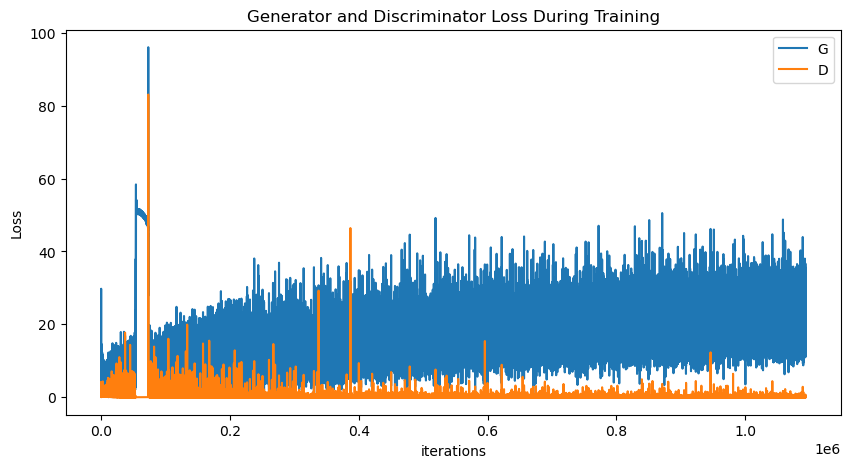

In [29]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()


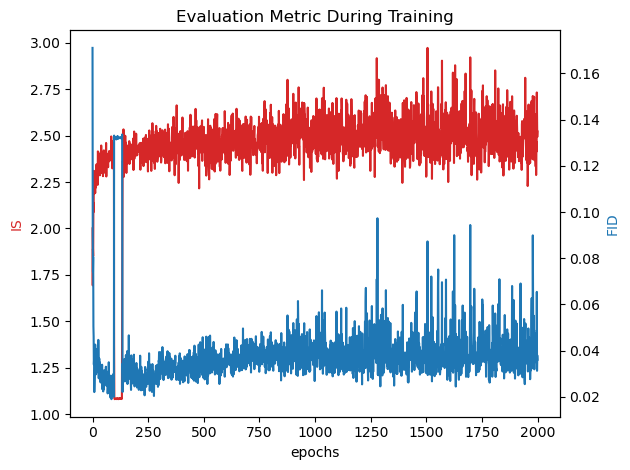

In [30]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()


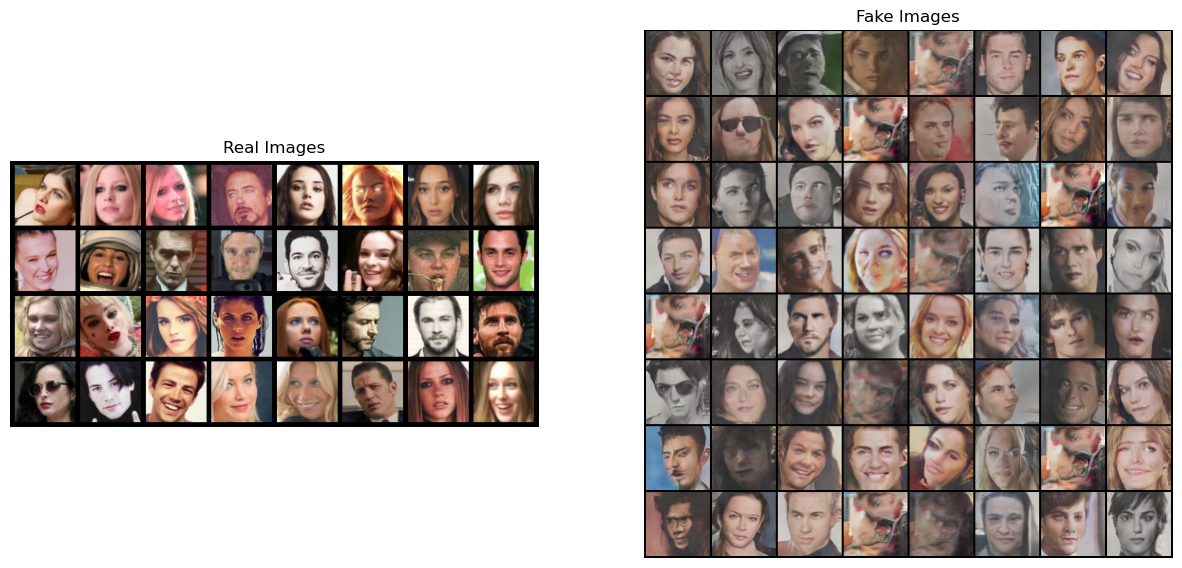

In [31]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))


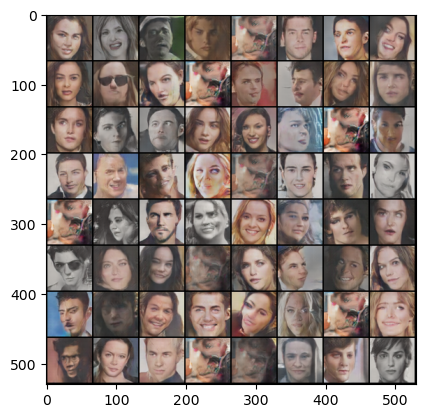

In [32]:
if img_list:
    plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))
else:
    print("img_list is empty")


In [33]:
img_list = []  # Inisialisasi img_list sebelum digunakan

# Kemudian Anda dapat menambahkan logika untuk menambahkan gambar-gambar ke img_list selama pelatihan
# Setelah Anda yakin img_list sudah terisi dengan elemen, Anda dapat menggunakan blok if seperti yang Anda tunjukkan:
if img_list:
    plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))
else:
    print("img_list is empty")


img_list is empty


In [34]:
# Menyimpan model discriminator
disc_path = "C:\\Users\\Ilmu Komputer\\OneDrive\\Desktop\\DCGAN Face\Model\\disc_model.pt"
torch.save(netD.state_dict(), disc_path)

# Menyimpan model generator
gen_path = "C:\\Users\\Ilmu Komputer\\OneDrive\\Desktop\\DCGAN Face\Model\\gen_model.pt"
torch.save(netG.state_dict(), gen_path)

print("Models saved successfully.")

Models saved successfully.


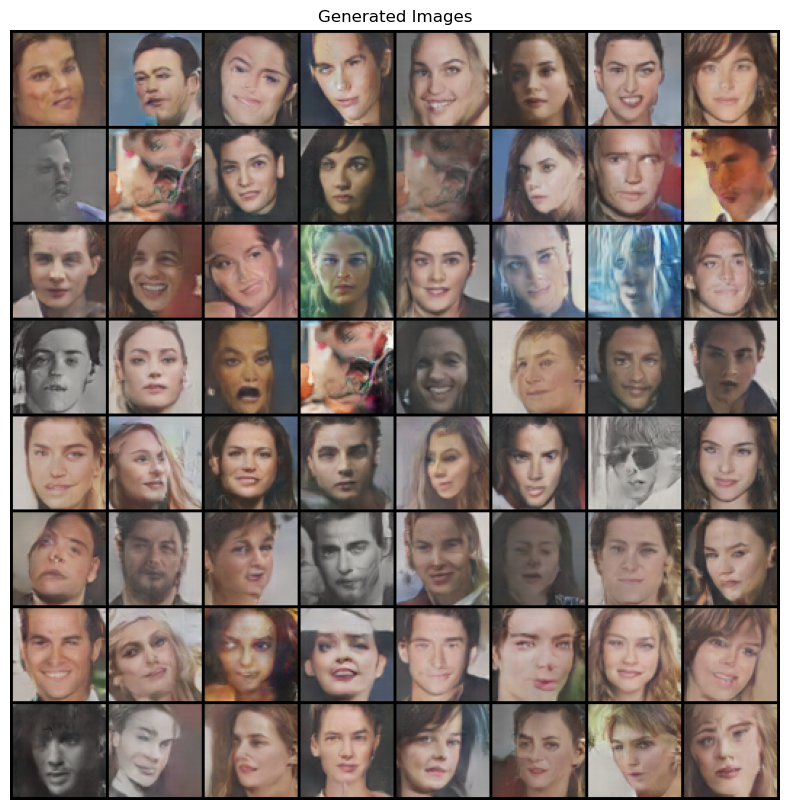

In [16]:
# Muat model generator
gen_path = "C:\\Users\\Ilmu Komputer\\OneDrive\\Desktop\\DCGAN Face\Model\\gen_model.pt"
netG = Generator3x64x64(latent_dim)
netG.load_state_dict(torch.load(gen_path))
netG.eval()
# Buat noise acak
fixed_noise = torch.randn(64, latent_dim, 1, 1)
# Menghasilkan gambar palsu
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()
# Menampilkan gambar palsu yang dihasilkan
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [12]:
from torchvision.utils import save_image
# Modifikasi fungsi save_generated_images
def save_generated_images(generator, num_images, save_path, device, latent_dim):
    generator.eval()  # Pastikan generator dalam mode evaluasi
    os.makedirs(save_path, exist_ok=True)  # Buat direktori penyimpanan jika belum ada
    
    # Generate num_images gambar
    with torch.no_grad():
        for i in range(num_images):
            # Generate gambar dengan generator
            noise = torch.randn(1, latent_dim, 1, 1).to(device)
            fake_image = generator(noise)
            
            # Normalisasi kembali gambar sebelum disimpan
            normalized_fake_image = (fake_image + 1) / 2  # Normalisasi ke rentang [0, 1]
            
            # Simpan gambar hasil ke file
            save_image(normalized_fake_image[0], os.path.join(save_path, f'generated_image_{i+1}.png'))

# Contoh penggunaan
if __name__ == '__main__':
    # Contoh parameter
    num_images = 150  # Jumlah gambar yang ingin digenerate
    save_path = "C:\\Users\\Ilmu Komputer\\OneDrive\\Desktop\\DCGAN Face\\Sample"
    latent_dim = 100  # Dimensi dari vektor laten yang digunakan dalam generator
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Gunakan GPU jika tersedia, jika tidak gunakan CPU
    
    # Ganti dengan model GAN Anda
    generator = Generator3x64x64(latent_dim).to(device)
    generator.load_state_dict(torch.load(gen_path))  # Load weights jika diperlukan
    
    # Panggil fungsi untuk menyimpan gambar hasil
    save_generated_images(generator, num_images, save_path, device, latent_dim)
